In [2]:
#### Import de libraries
import seaborn as sns
import math
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import numpy as np
import importlib
import functions
from tqdm import tqdm 

In [3]:
warnings.filterwarnings("ignore")

In [5]:
X_train_reg = pd.read_csv('X_train_final.csv')
X_test_reg = pd.read_csv('X_test_final.csv')
X_oot_reg = pd.read_csv('X_oot_final.csv')

In [6]:
final_selected_vars=X_train_reg.columns.to_list()
final_selected_vars

['SECTNAF',
 'CODETAJUR_I_dis',
 'evol_line_deb_cr_dis',
 'ratio_cred_ma_dis',
 'CRTOC_MOY_MVTAFF_IND_0010_dis',
 'CRTOC_AG_MVTAFF_2T_IND_0010_dis',
 'CRTOC_AG_NBJCRE_2T_IND_0009_dis',
 'CRTOC_IND_0164_dis',
 'CRTOC_AG_LIGDEB_2T_IND_0015_dis',
 'CRTOC_IND_0015_dis',
 'DDefaut_NDB',
 'datdelhis',
 'CODNAF2']

In [7]:
cible="DDefaut_NDB"
date="datdelhis"
codnaf = "CODNAF2"

In [8]:
final_selected_vars.remove(cible)
final_selected_vars.remove(date)
final_selected_vars.remove(codnaf)

In [9]:
final_selected_vars

['SECTNAF',
 'CODETAJUR_I_dis',
 'evol_line_deb_cr_dis',
 'ratio_cred_ma_dis',
 'CRTOC_MOY_MVTAFF_IND_0010_dis',
 'CRTOC_AG_MVTAFF_2T_IND_0010_dis',
 'CRTOC_AG_NBJCRE_2T_IND_0009_dis',
 'CRTOC_IND_0164_dis',
 'CRTOC_AG_LIGDEB_2T_IND_0015_dis',
 'CRTOC_IND_0015_dis']

In [10]:
y_train = X_train_reg[cible].values.flatten()  # Convert to 1D numpy array
y_test = X_test_reg[cible].values.flatten()  
y_oot = X_oot_reg[cible].values.flatten()  

Avant de construire le modèle, il faut s’assurer que les modalités des variables sont stables et robustes, il faut vérifier certains critères. Ces critères sont les suivants : 
- Les modalités doivent être stables en taux du critère à modéliser (pas de croisement entre les modalités au cours du temps) et en volumétrie ;
- Un effectif minimum de 5% de la population doit être trouvé dans chaque modalité (à l’exception, de variable particulièrement explicative du critère à modéliser et
particulièrement fiable, pour exemple, dans le cadre de score de risque, pour des variables de dépassement d’autorisation ou d’impayé un effectif moindre est toléré) ;
- Les modalités doivent être séparée d’au moins 30% relatif en termes de taux de variable cible.

De fait, les analyses ci-dessous sont réalisées pour vérifier ces critères. On va utiliser également le PSI (Population Stability Index) pour vérifier la stabilité des modalités.

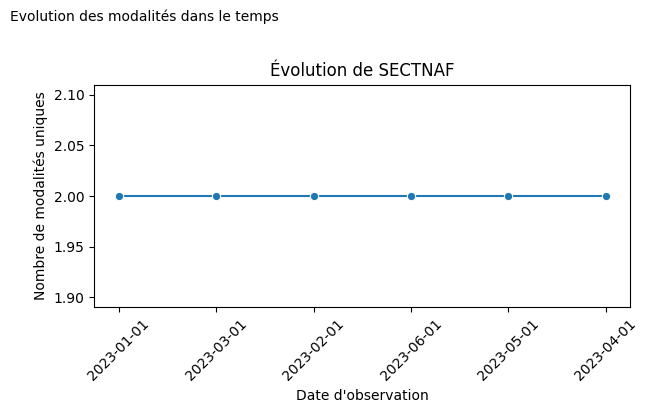

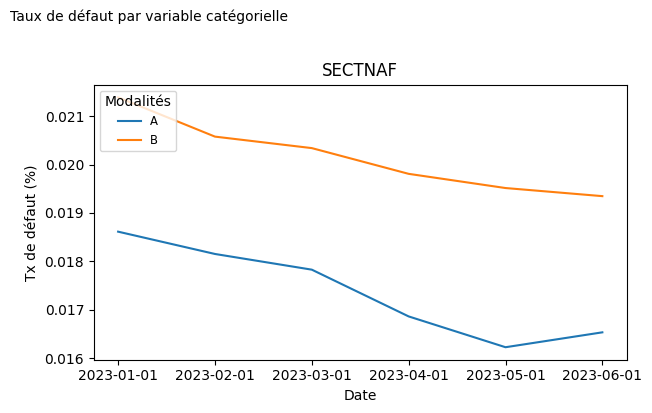

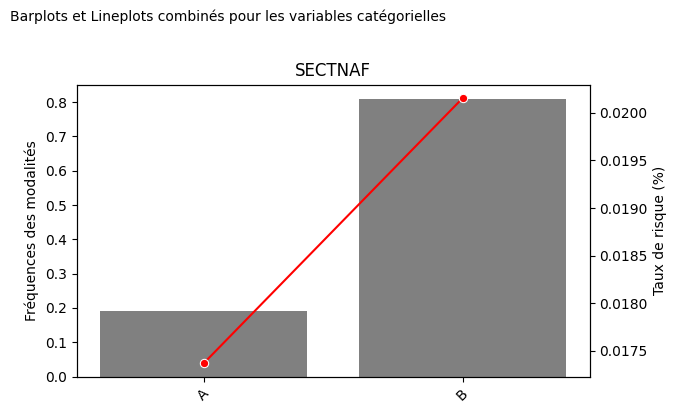

Aucune variable n'a de modalités avec moins de 5% d'effectifs.
  SECTNAF  taux_cible  ecart_relatif
0       A    0.017368       0.000000
1       B    0.020156      16.052537


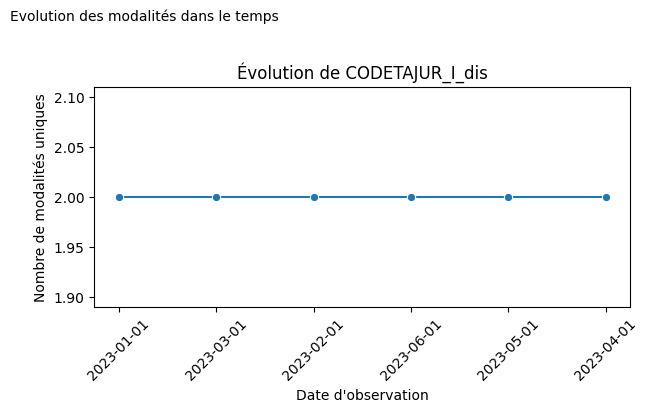

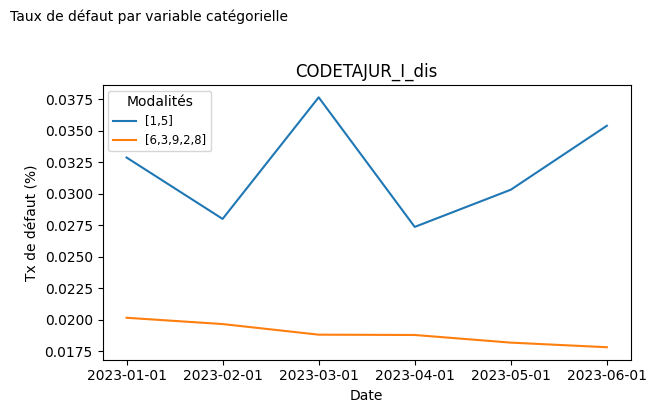

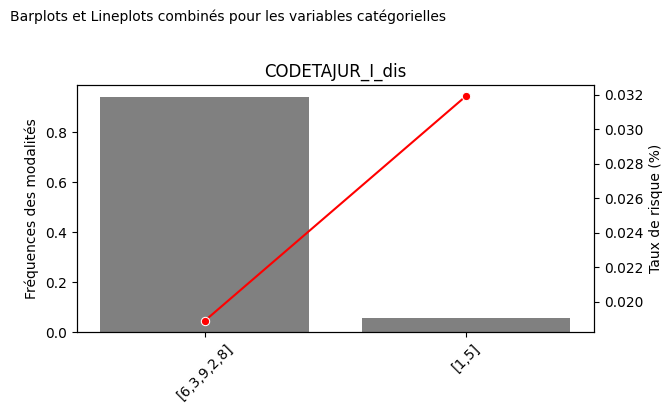

Aucune variable n'a de modalités avec moins de 5% d'effectifs.
  CODETAJUR_I_dis  taux_cible  ecart_relatif
0     [6,3,9,2,8]    0.018884       0.000000
1           [1,5]    0.031932      69.096032


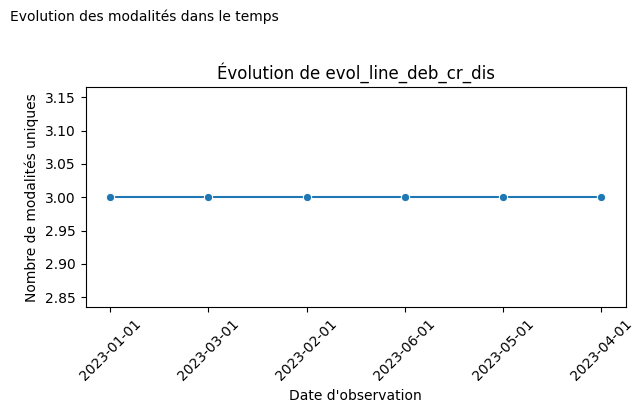

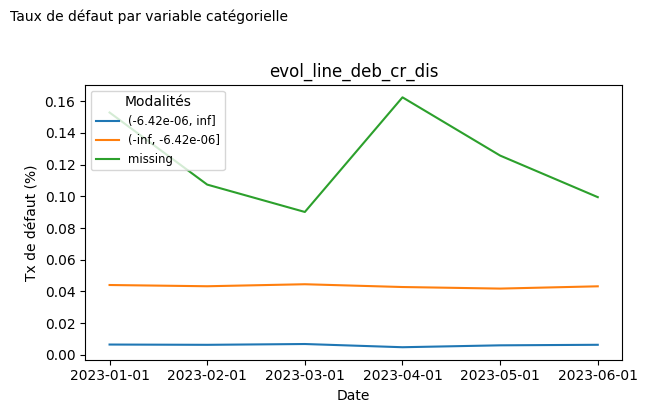

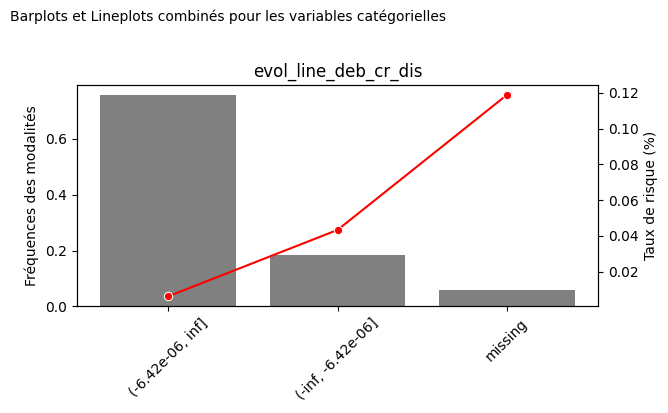

Aucune variable n'a de modalités avec moins de 5% d'effectifs.
  evol_line_deb_cr_dis  taux_cible  ecart_relatif
0     (-6.42e-06, inf]    0.006142       0.000000
1    (-inf, -6.42e-06]    0.043285     604.777378
2              missing    0.118805     174.473933


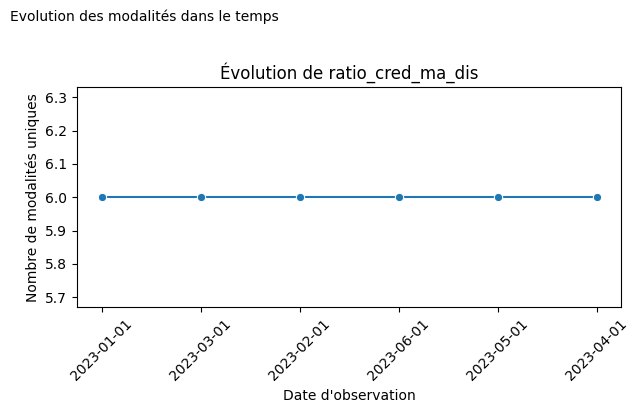

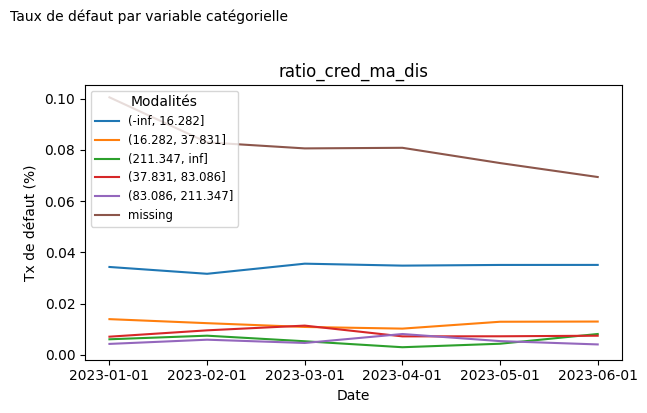

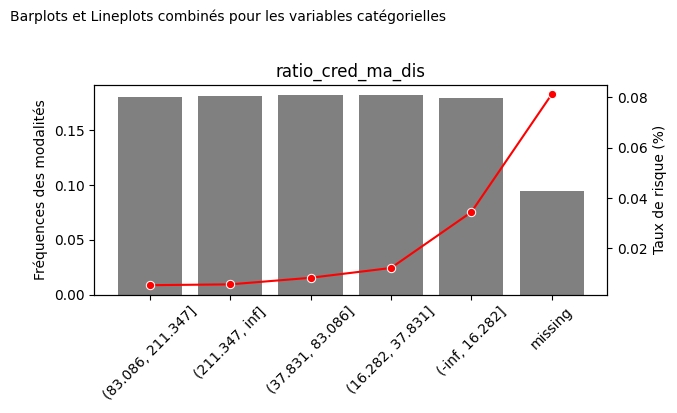

Aucune variable n'a de modalités avec moins de 5% d'effectifs.
   ratio_cred_ma_dis  taux_cible  ecart_relatif
0  (83.086, 211.347]    0.005417       0.000000
1     (211.347, inf]    0.005745       6.055271
2   (37.831, 83.086]    0.008355      45.441911
3   (16.282, 37.831]    0.012246      46.568482
4     (-inf, 16.282]    0.034425     181.097640
5            missing    0.081208     135.901226


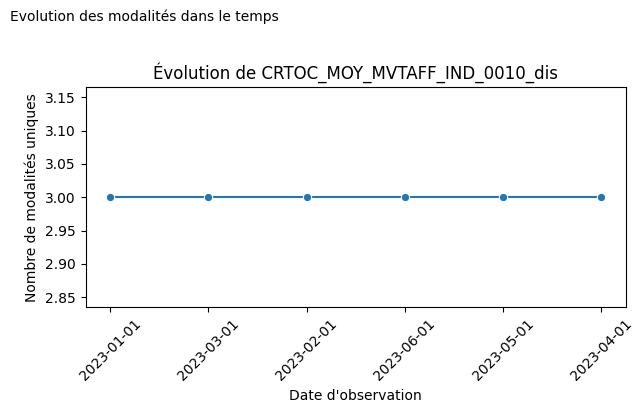

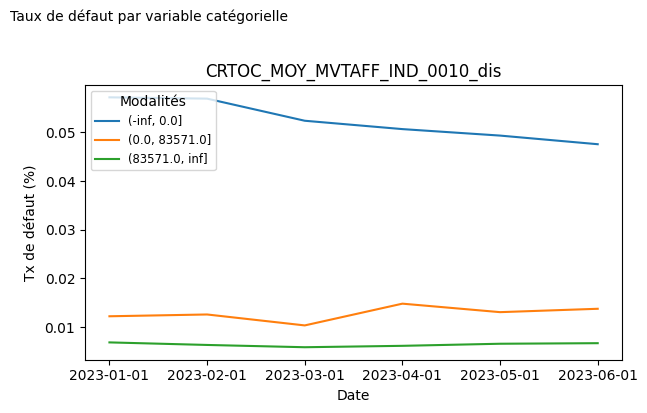

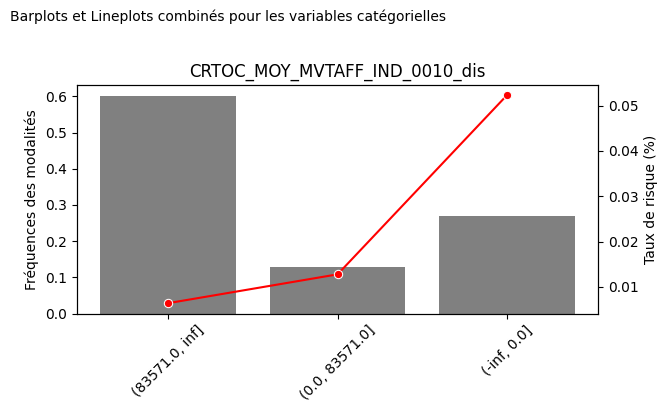

Aucune variable n'a de modalités avec moins de 5% d'effectifs.
  CRTOC_MOY_MVTAFF_IND_0010_dis  taux_cible  ecart_relatif
0                (83571.0, inf]    0.006422       0.000000
1                (0.0, 83571.0]    0.012776      98.955737
2                   (-inf, 0.0]    0.052278     309.186882


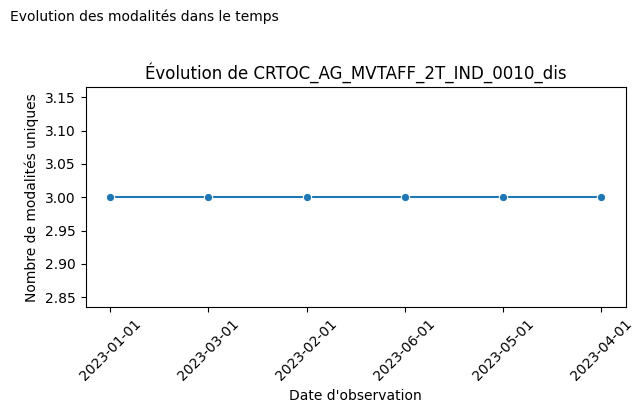

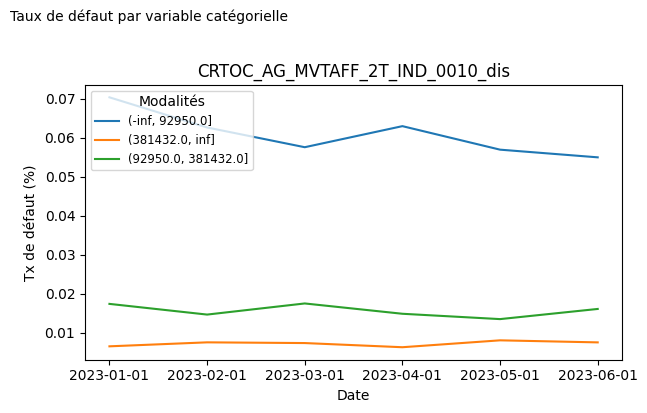

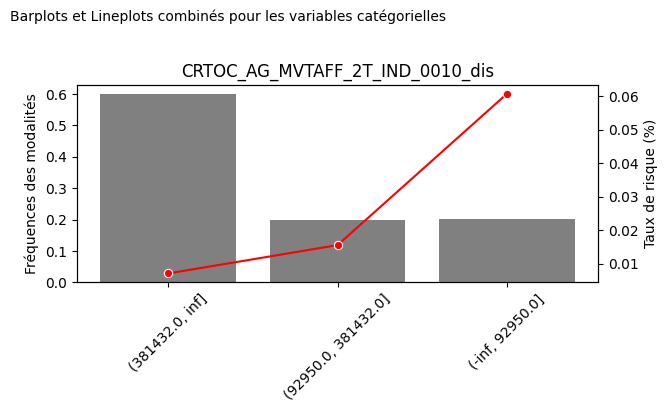

Aucune variable n'a de modalités avec moins de 5% d'effectifs.
  CRTOC_AG_MVTAFF_2T_IND_0010_dis  taux_cible  ecart_relatif
0                 (381432.0, inf]    0.007154       0.000000
1             (92950.0, 381432.0]    0.015609     118.201405
2                 (-inf, 92950.0]    0.060721     289.011530


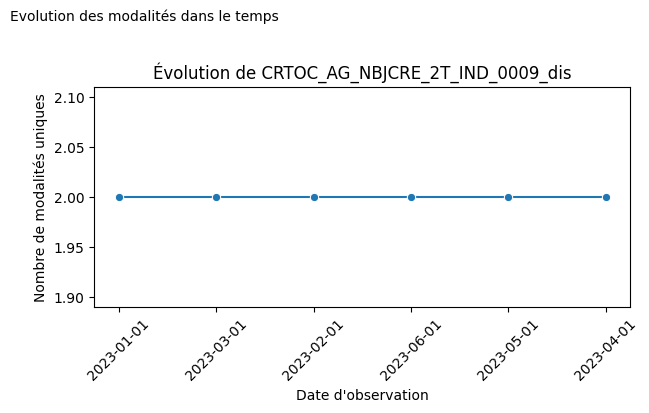

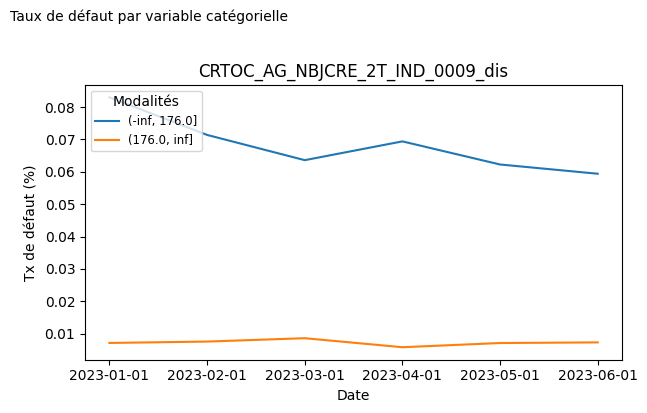

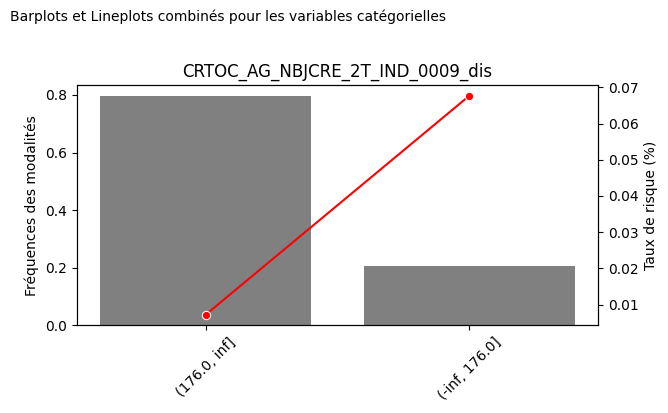

Aucune variable n'a de modalités avec moins de 5% d'effectifs.
  CRTOC_AG_NBJCRE_2T_IND_0009_dis  taux_cible  ecart_relatif
0                    (176.0, inf]    0.007258       0.000000
1                   (-inf, 176.0]    0.067669     832.374357


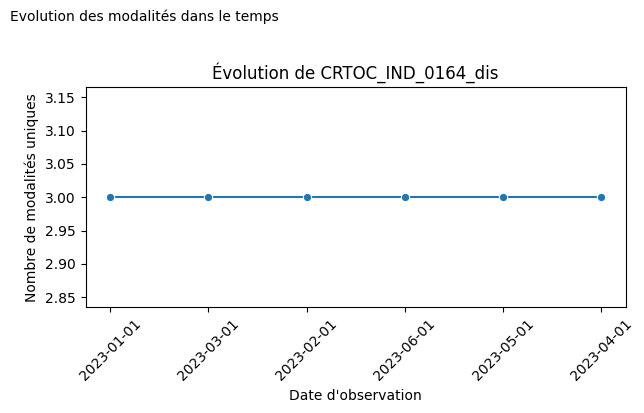

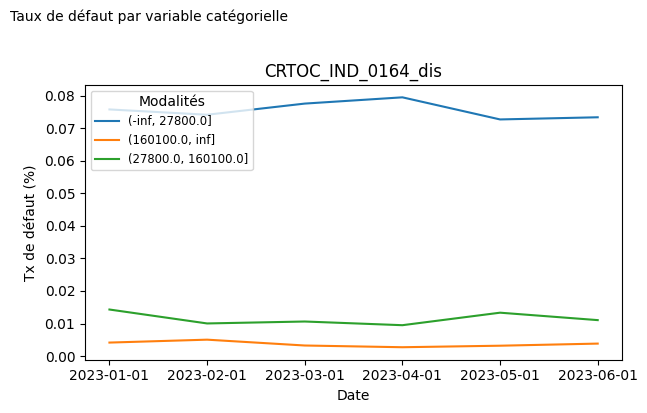

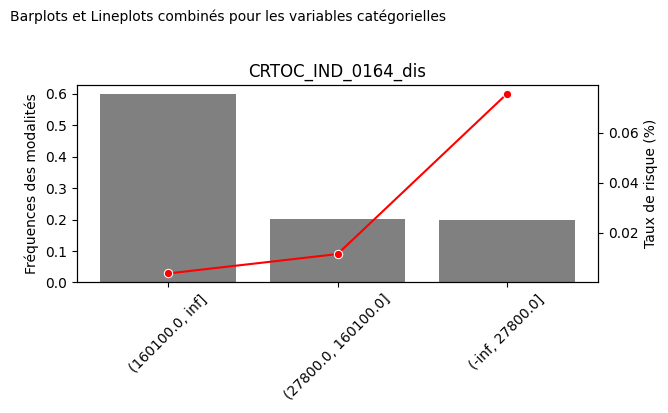

Aucune variable n'a de modalités avec moins de 5% d'effectifs.
    CRTOC_IND_0164_dis  taux_cible  ecart_relatif
0      (160100.0, inf]    0.003690       0.000000
1  (27800.0, 160100.0]    0.011453     210.425121
2      (-inf, 27800.0]    0.075508     559.269532


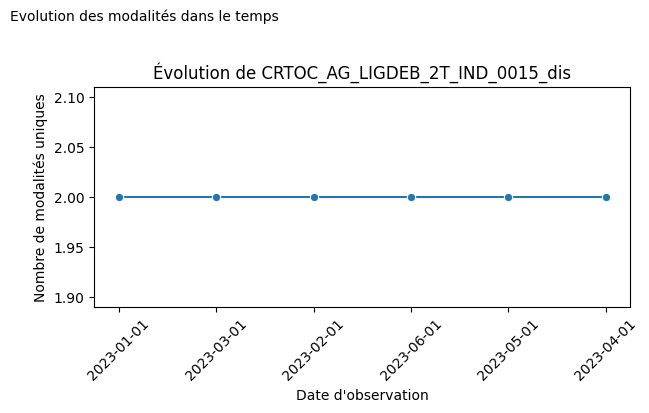

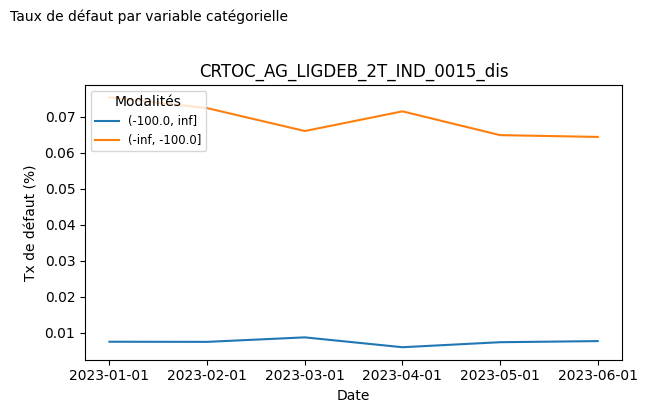

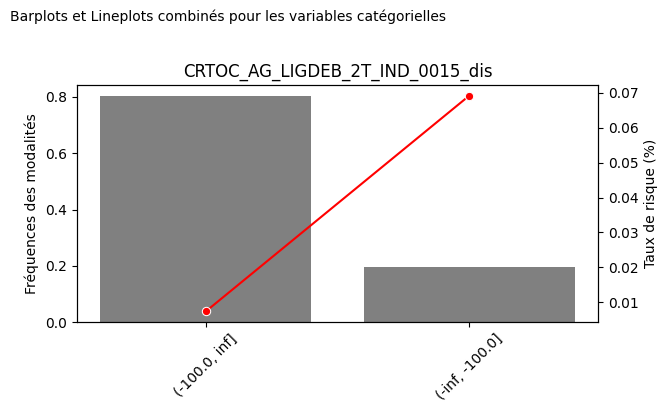

Aucune variable n'a de modalités avec moins de 5% d'effectifs.
  CRTOC_AG_LIGDEB_2T_IND_0015_dis  taux_cible  ecart_relatif
0                   (-100.0, inf]    0.007455       0.000000
1                  (-inf, -100.0]    0.069128     827.279039


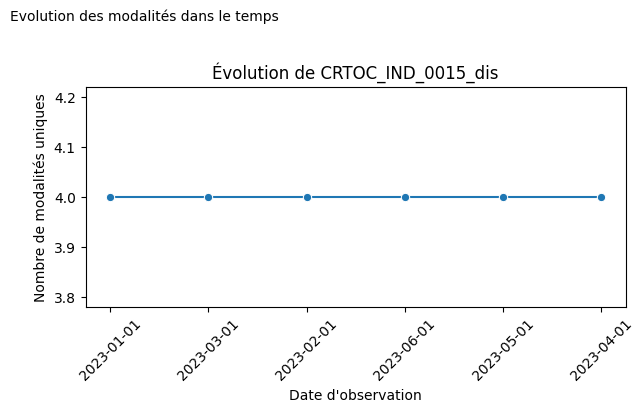

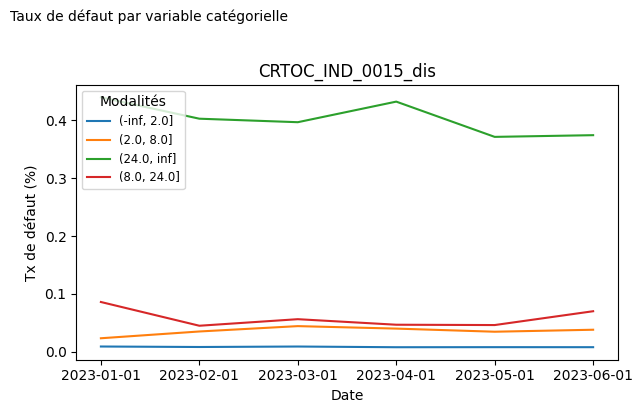

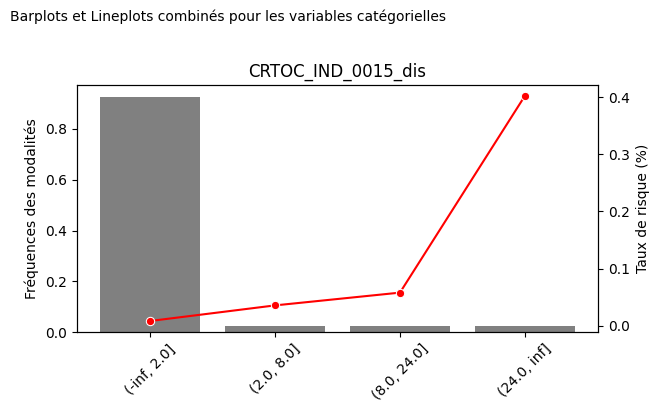

Les variables suivantes ont au moins une modalité avec une fréquence <= 5.0% :
['CRTOC_IND_0015_dis']
  CRTOC_IND_0015_dis  taux_cible  ecart_relatif
0        (-inf, 2.0]    0.008414       0.000000
1         (2.0, 8.0]    0.035670     323.928115
2        (8.0, 24.0]    0.057983      62.551921
3        (24.0, inf]    0.401790     592.945444


In [11]:
importlib.reload(functions)

for col in final_selected_vars :
    functions.plot_modalities_over_time(X_test_reg, date, [col])
    print("="*15)
    functions.tx_rsq_par_var(X_test_reg,[col],date,cible)
    print("="*15)
    functions.combined_barplot_lineplot(X_test_reg, [col], cible)
    print("="*15)
    functions.test_freq_by_group(X_test_reg, [col])
    print("="*15)
    print(functions.calculate_relative_difference(X_test_reg, col, cible))


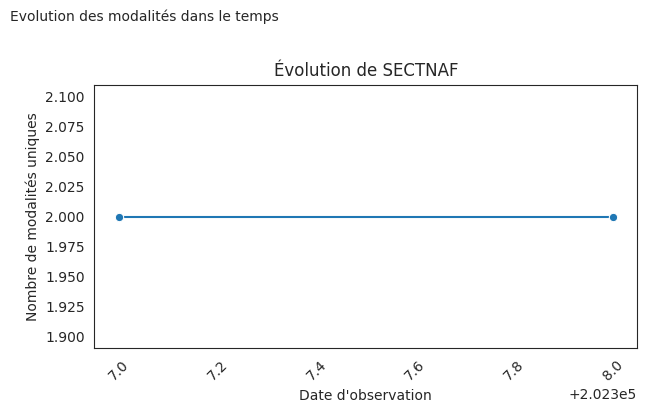

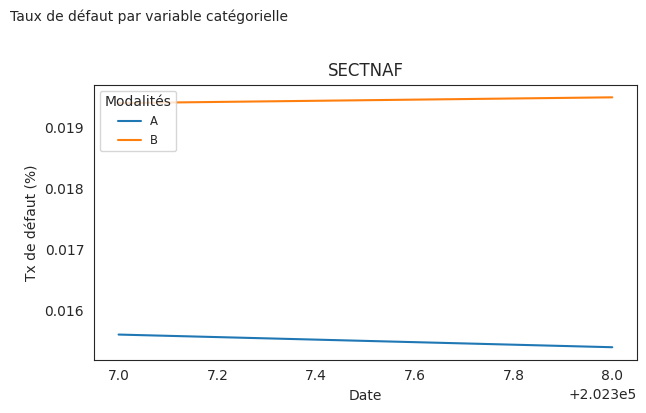

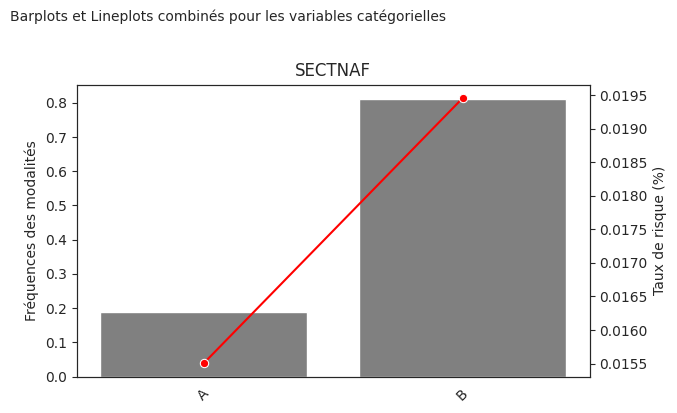

Aucune variable n'a de modalités avec moins de 5% d'effectifs.
  SECTNAF  taux_cible  ecart_relatif
0       A    0.015504       0.000000
1       B    0.019455      25.482733


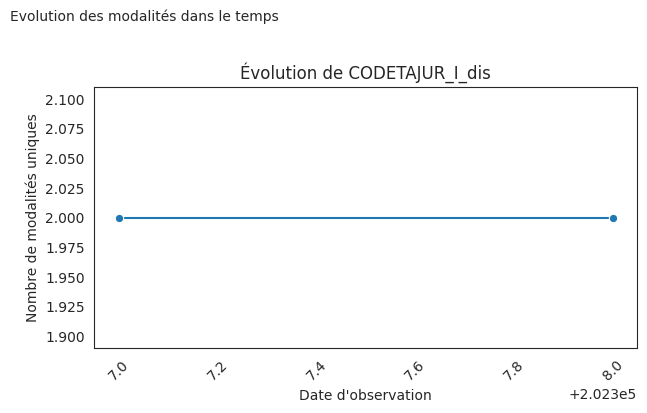

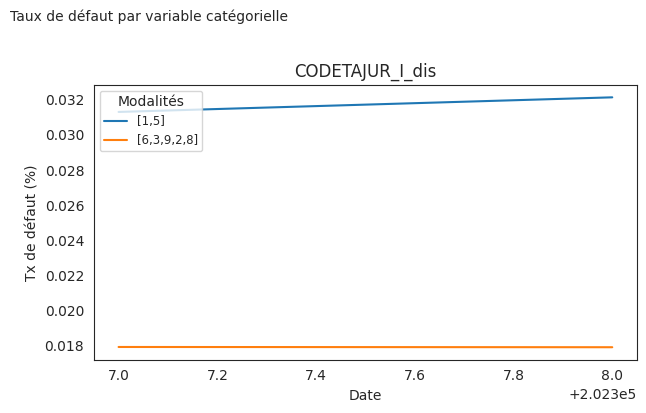

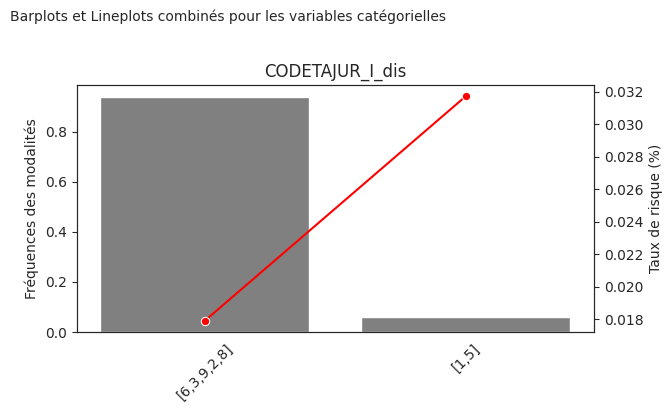

Aucune variable n'a de modalités avec moins de 5% d'effectifs.
  CODETAJUR_I_dis  taux_cible  ecart_relatif
0     [6,3,9,2,8]    0.017898       0.000000
1           [1,5]    0.031732      77.293289


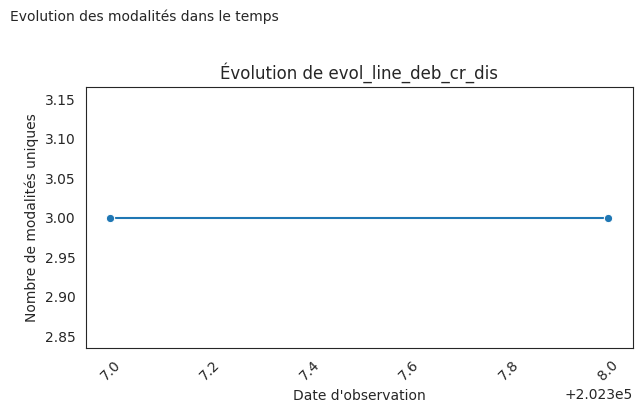

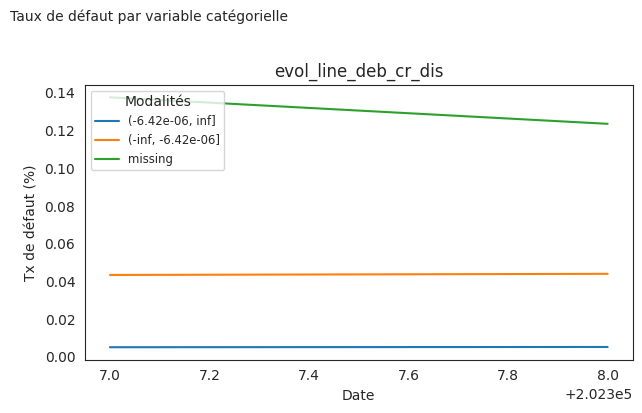

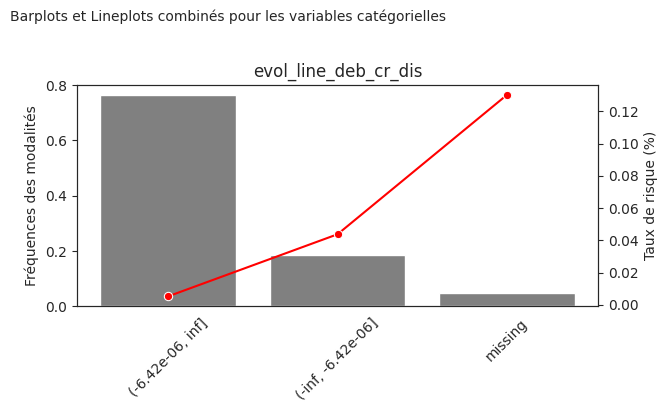

Aucune variable n'a de modalités avec moins de 5% d'effectifs.
  evol_line_deb_cr_dis  taux_cible  ecart_relatif
0     (-6.42e-06, inf]    0.005238       0.000000
1    (-inf, -6.42e-06]    0.043773     735.696355
2              missing    0.130275     197.617065


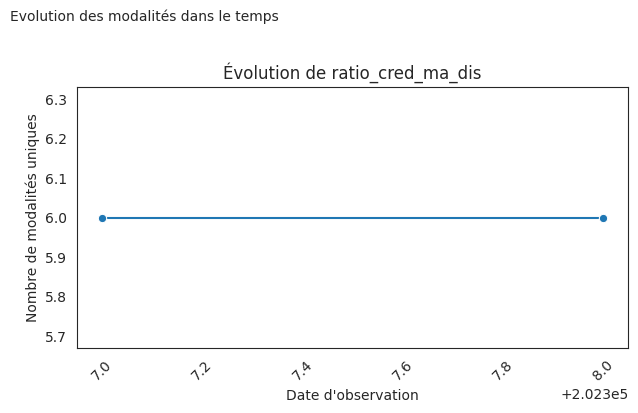

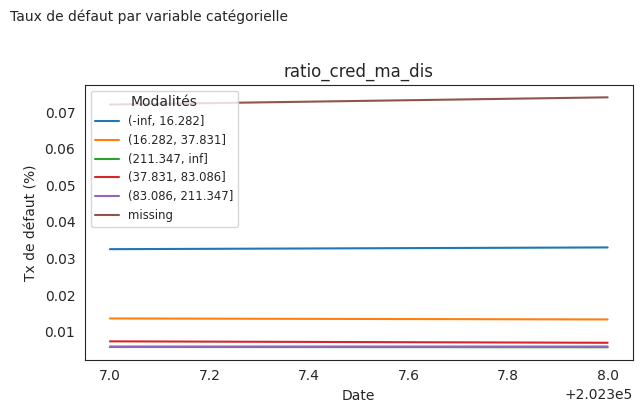

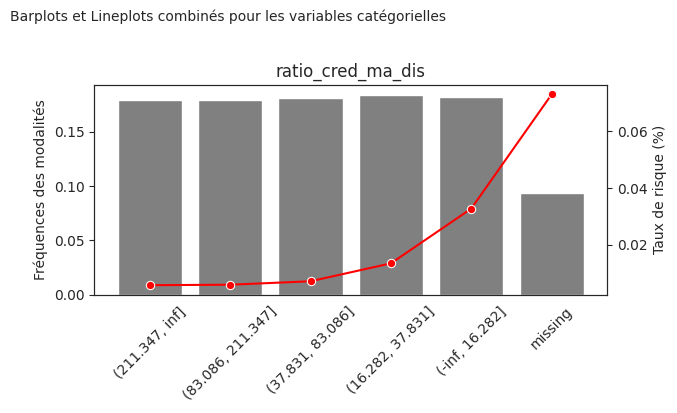

Aucune variable n'a de modalités avec moins de 5% d'effectifs.
   ratio_cred_ma_dis  taux_cible  ecart_relatif
0     (211.347, inf]    0.005819       0.000000
1  (83.086, 211.347]    0.005985       2.850303
2   (37.831, 83.086]    0.007198      20.271003
3   (16.282, 37.831]    0.013508      87.653883
4     (-inf, 16.282]    0.032806     142.868210
5            missing    0.073038     122.635824


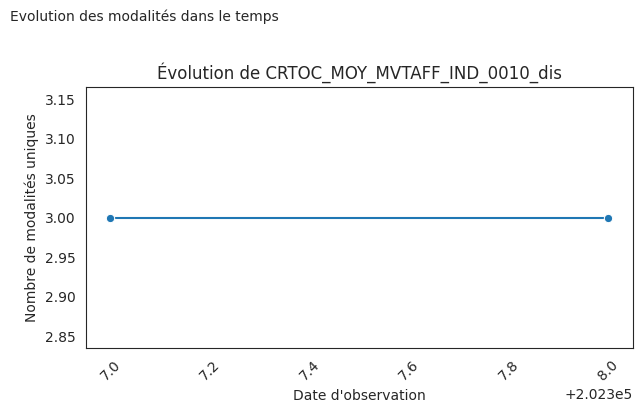

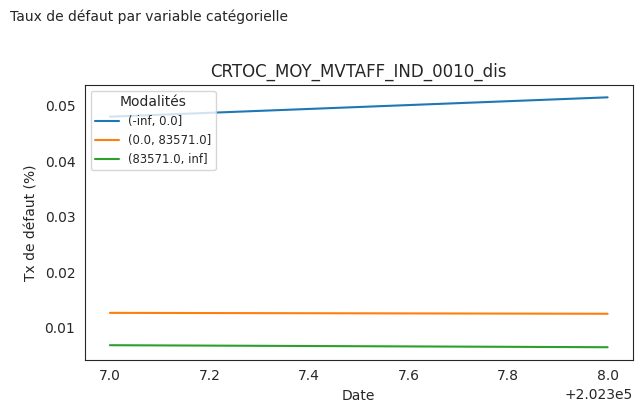

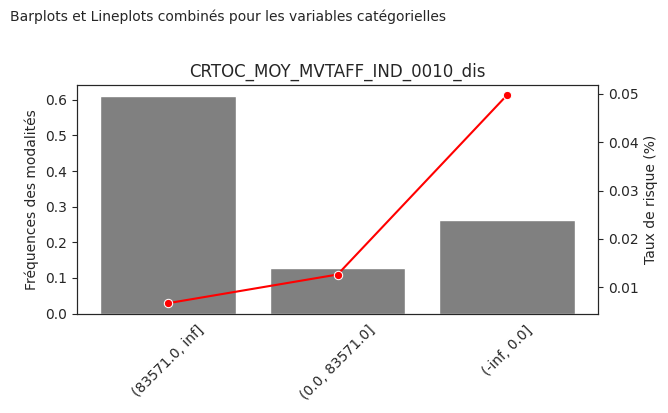

Aucune variable n'a de modalités avec moins de 5% d'effectifs.
  CRTOC_MOY_MVTAFF_IND_0010_dis  taux_cible  ecart_relatif
0                (83571.0, inf]    0.006710       0.000000
1                (0.0, 83571.0]    0.012637      88.314341
2                   (-inf, 0.0]    0.049731     293.538980


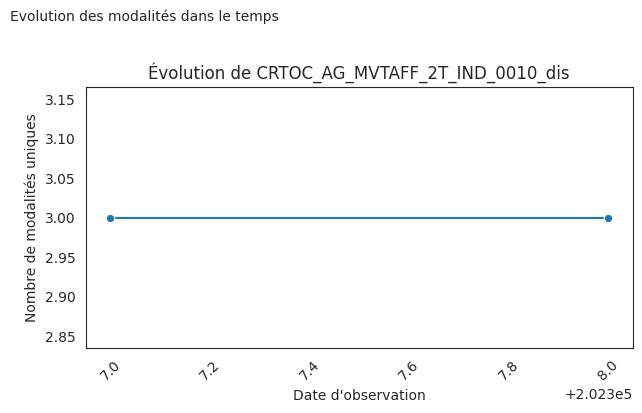

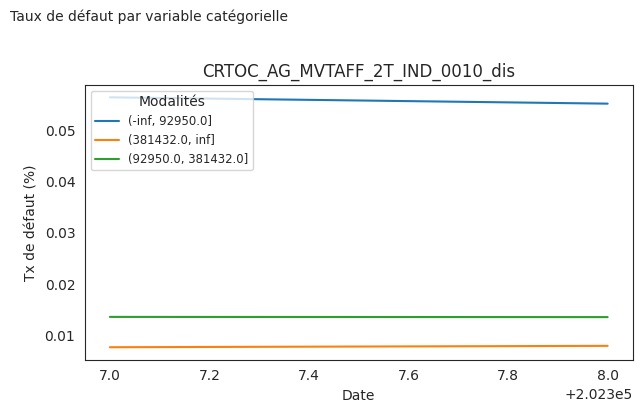

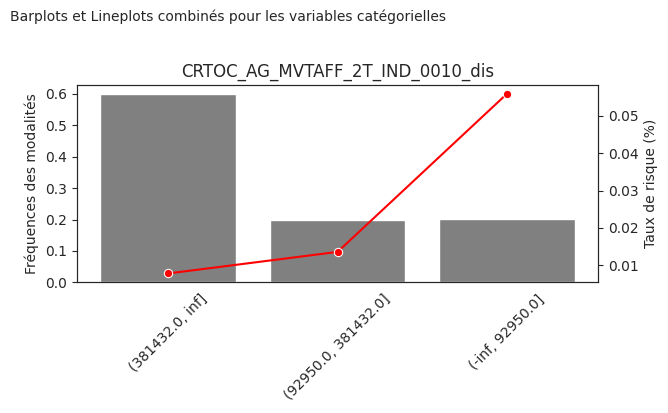

Aucune variable n'a de modalités avec moins de 5% d'effectifs.
  CRTOC_AG_MVTAFF_2T_IND_0010_dis  taux_cible  ecart_relatif
0                 (381432.0, inf]    0.007809       0.000000
1             (92950.0, 381432.0]    0.013580      73.901406
2                 (-inf, 92950.0]    0.055882     311.517361


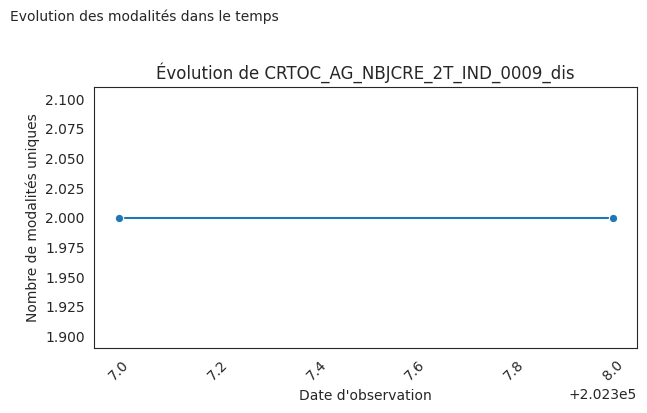

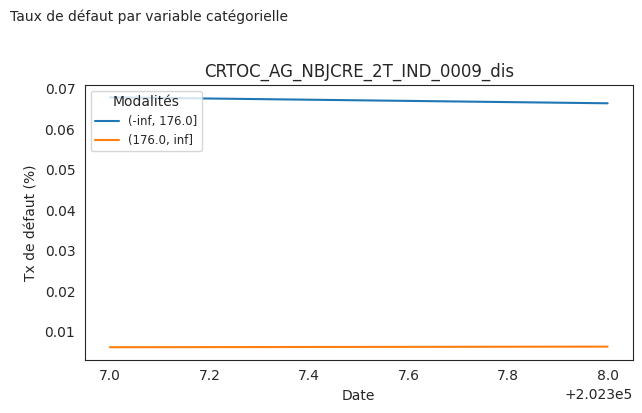

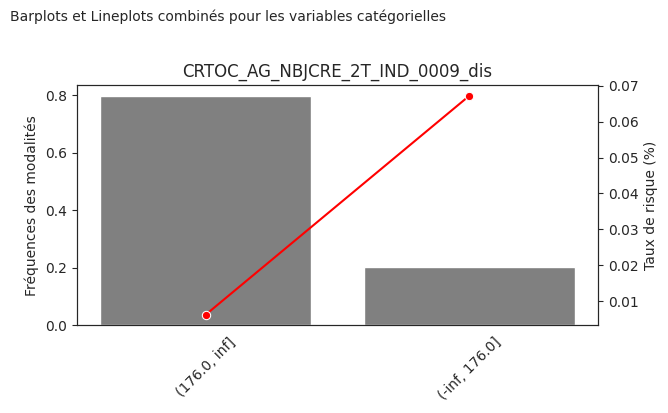

Aucune variable n'a de modalités avec moins de 5% d'effectifs.
  CRTOC_AG_NBJCRE_2T_IND_0009_dis  taux_cible  ecart_relatif
0                    (176.0, inf]    0.006315       0.000000
1                   (-inf, 176.0]    0.067178     963.861482


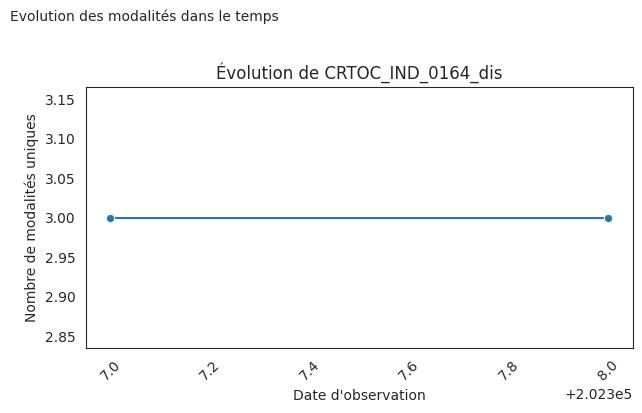

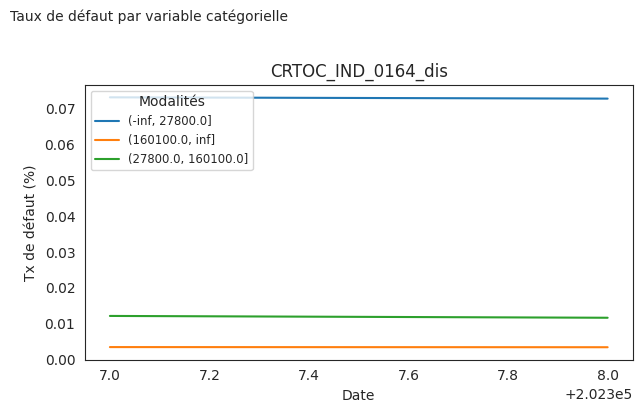

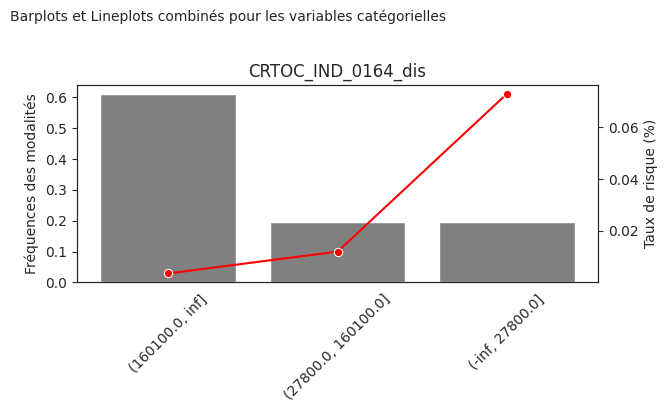

Aucune variable n'a de modalités avec moins de 5% d'effectifs.
    CRTOC_IND_0164_dis  taux_cible  ecart_relatif
0      (160100.0, inf]    0.003500       0.000000
1  (27800.0, 160100.0]    0.011951     241.444495
2      (-inf, 27800.0]    0.072971     510.562076


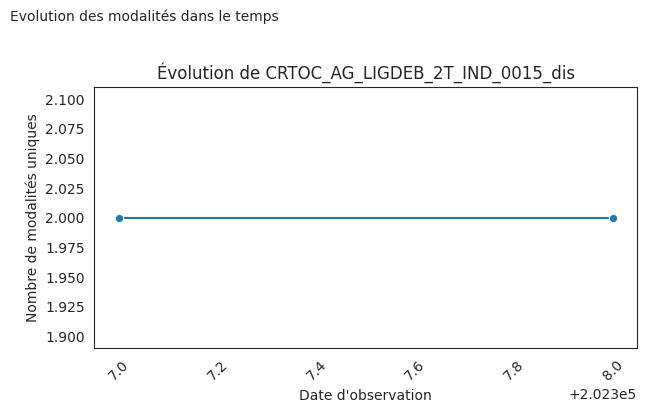

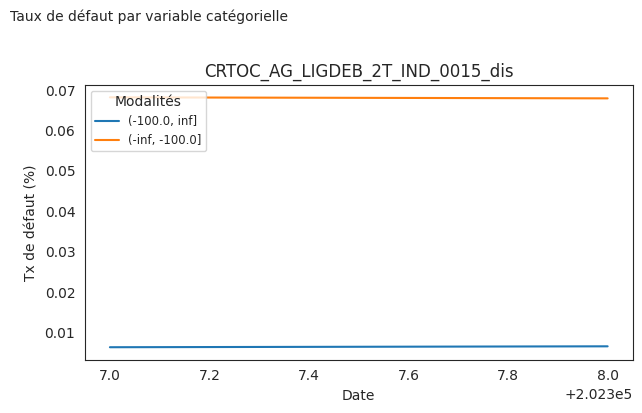

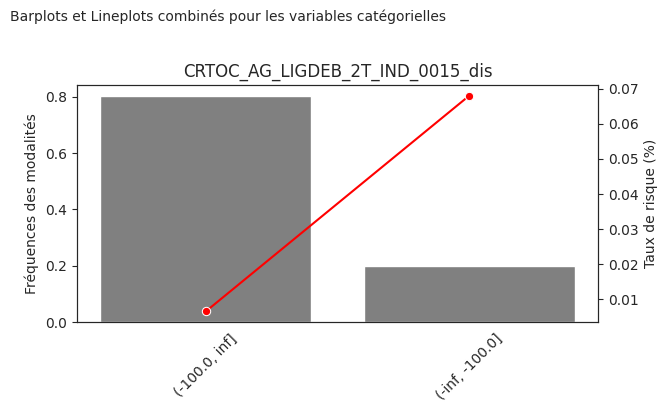

Aucune variable n'a de modalités avec moins de 5% d'effectifs.
  CRTOC_AG_LIGDEB_2T_IND_0015_dis  taux_cible  ecart_relatif
0                   (-100.0, inf]    0.006536       0.000000
1                  (-inf, -100.0]    0.068072     941.424378


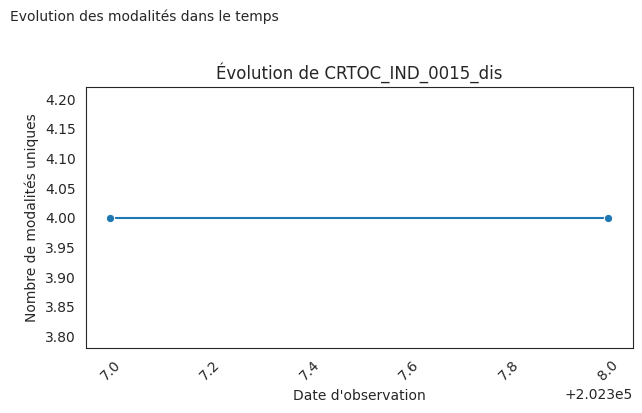

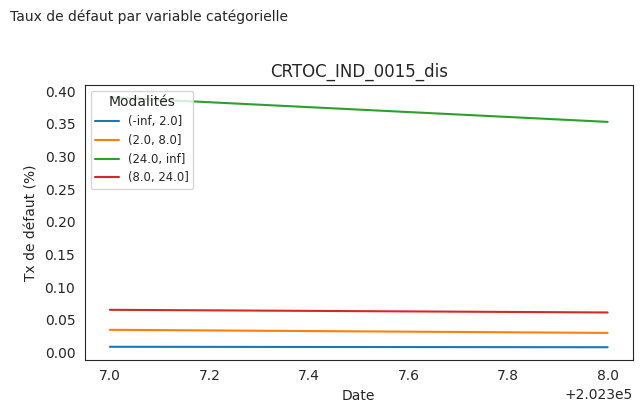

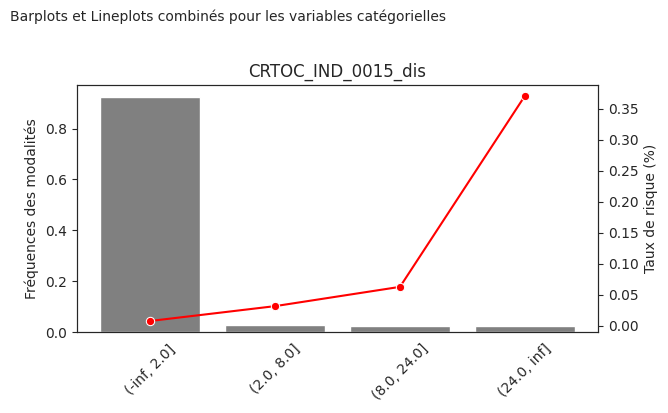

Les variables suivantes ont au moins une modalité avec une fréquence <= 5.0% :
['CRTOC_IND_0015_dis']
  CRTOC_IND_0015_dis  taux_cible  ecart_relatif
0        (-inf, 2.0]    0.008017       0.000000
1         (2.0, 8.0]    0.031915     298.069029
2        (8.0, 24.0]    0.062935      97.197347
3        (24.0, inf]    0.370215     488.246549


In [90]:
importlib.reload(functions)

for col in final_selected_vars :
    functions.plot_modalities_over_time(X_oot_reg, date, [col])
    print("="*15)
    functions.tx_rsq_par_var(X_oot_reg,[col],date,cible)
    print("="*15)
    functions.combined_barplot_lineplot(X_oot_reg, [col], cible)
    print("="*15)
    functions.test_freq_by_group(X_oot_reg, [col])
    print("="*15)
    print(functions.calculate_relative_difference(X_oot_reg, col, cible))


# 0. Variables finales retenues pour la modélisation

Text(0.5, 1.0, 'Variables catégorielles dépendantes de la variable cible')

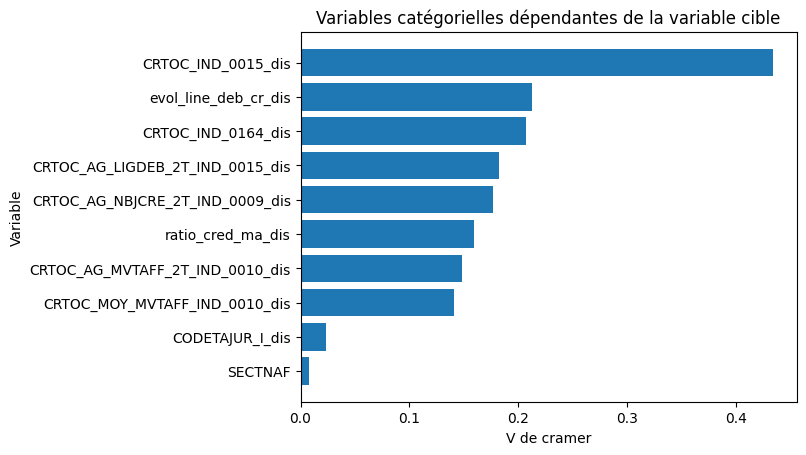

In [12]:
importlib.reload(functions)
cramer_cible_res=functions.compute_cramers_v(X_train_reg, final_selected_vars,cible).sort_values(by = "Cramer_V", ascending=True).round(3)

plt.barh(cramer_cible_res['Columns'], cramer_cible_res["Cramer_V"])

# Ajoutez des étiquettes et un titre
plt.xlabel('V de cramer')
plt.ylabel('Variable')
plt.title('Variables catégorielles dépendantes de la variable cible')

In [13]:
# Trier par ordre décroissant de "Cramer_V"
from pprint import pprint
cramer_cible_res_sorted = cramer_cible_res.sort_values(by="Cramer_V", ascending=False)

# Récupérer uniquement les noms des colonnes
column_names_sorted = cramer_cible_res_sorted['Columns'].tolist()

# Afficher les résultats
pprint(column_names_sorted)

['CRTOC_IND_0015_dis',
 'evol_line_deb_cr_dis',
 'CRTOC_IND_0164_dis',
 'CRTOC_AG_LIGDEB_2T_IND_0015_dis',
 'CRTOC_AG_NBJCRE_2T_IND_0009_dis',
 'ratio_cred_ma_dis',
 'CRTOC_AG_MVTAFF_2T_IND_0010_dis',
 'CRTOC_MOY_MVTAFF_IND_0010_dis',
 'CODETAJUR_I_dis',
 'SECTNAF']


In [14]:
# Ajouter "DDefaut_NDB" à la première position de la liste
column_names_sorted.insert(0, "DDefaut_NDB")

# Afficher le résultat
pprint(column_names_sorted)

['DDefaut_NDB',
 'CRTOC_IND_0015_dis',
 'evol_line_deb_cr_dis',
 'CRTOC_IND_0164_dis',
 'CRTOC_AG_LIGDEB_2T_IND_0015_dis',
 'CRTOC_AG_NBJCRE_2T_IND_0009_dis',
 'ratio_cred_ma_dis',
 'CRTOC_AG_MVTAFF_2T_IND_0010_dis',
 'CRTOC_MOY_MVTAFF_IND_0010_dis',
 'CODETAJUR_I_dis',
 'SECTNAF']


<Axes: >

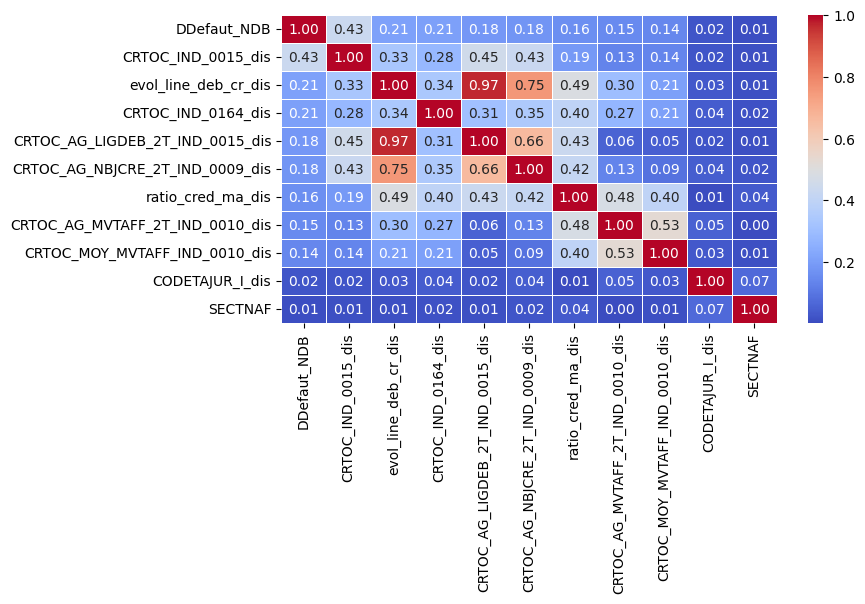

In [15]:
importlib.reload(functions)
p_value_df,cramer_v_df=functions.stats_liaisons_var_quali(X_train_reg,column_names_sorted)
np.fill_diagonal(cramer_v_df.values, 1)

# Créer la heatmap
plt.figure(figsize=(8, 4))  # Vous pouvez ajuster la taille de la figure si nécessaire
sns.heatmap(cramer_v_df.astype(float), cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5) 

Pour finalemet retenir les variables à inclure dans notre modèle, on a refait un v de cramer afin de garder les variables les moins corrélées entre elles. On considère ici un seuil de 0.6 pour le V de cramer.

In [16]:
### Variables retenues pour la suite

selected_vars = [
    'DDefaut_NDB',
    'CRTOC_IND_0015_dis',
    'evol_line_deb_cr_dis',
    'CRTOC_IND_0164_dis',
    'ratio_cred_ma_dis',
    'CRTOC_AG_MVTAFF_2T_IND_0010_dis',
    'CRTOC_MOY_MVTAFF_IND_0010_dis',
    'CODETAJUR_I_dis',
    'SECTNAF']

<Axes: >

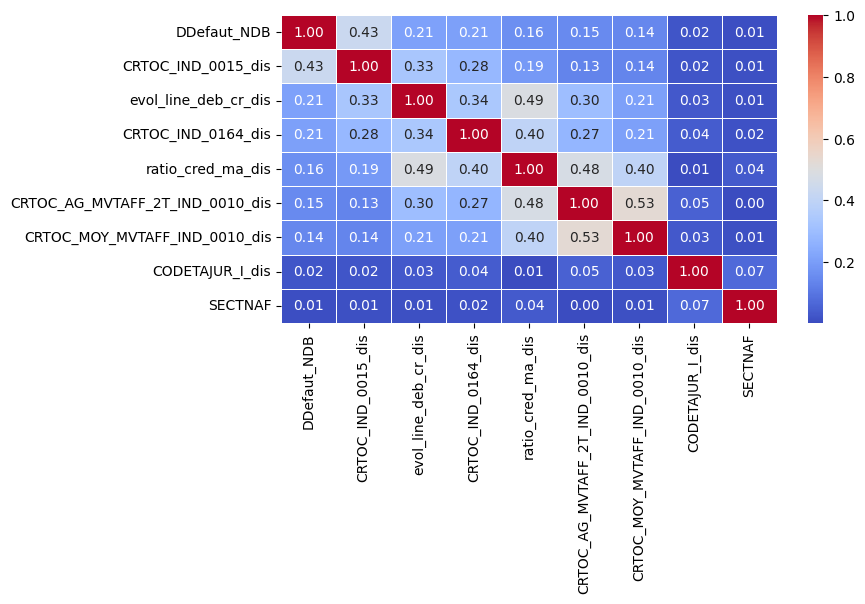

In [17]:
importlib.reload(functions)
p_value_df,cramer_v_df=functions.stats_liaisons_var_quali(X_train_reg,selected_vars)
np.fill_diagonal(cramer_v_df.values, 1)

# Créer la heatmap
plt.figure(figsize=(8, 4))  # Vous pouvez ajuster la taille de la figure si nécessaire
sns.heatmap(cramer_v_df.astype(float), cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5) 

In [19]:
selected_vars.pop(0)

'DDefaut_NDB'

On vérifie pour chaque variable (et donc notamment à chaque fois qu’une variable est ajoutée dans les modèles itératifs, mais aussi au global dans les modèles
automatiques) que :
- Les coefficients de chaque modalité sont significatifs (5% en général, 10% accepté si nécessaire) ;
- La significativité globale des coefficients est ok (5%) ;
- Les coefficients sont croissants avec le risque de la modalité (par construction, la modalité 2 et moins risquée que la 3. Le coef de la modalité 3 doit donc etre
plus grand que celui de la 2) ;
- Les odds ratios sont significatifs entre chaque modalités d’une même variables (positifs et que leur IC ne contiennent pas 1).

# I. Construction du modèle

## I.1 Démarche estimation du meilleur modèle logistique (1)

In [20]:
importlib.reload(functions)

cat_vars = []  # To store the selected variables
results= []
model_summaries = {}  # To store model summaries for each iteration
for i, col in tqdm(enumerate(selected_vars)):
    cat_vars.append(col)
    gini_index_train, auc_pr_train, gini_index_test, auc_pr_test, gini_index_oot, auc_pr_oot, flag_significativite, \
    flag_VIF, flag_OR,model_train, modalites_reference = functions.logit_reg(cat_vars, cible, y_train,X_train_reg,y_test, X_test_reg,y_oot, X_oot_reg)
    # Stocker les résultats
    results.append({
        "Nb de variables": i+1,
        "Variables": cat_vars.copy(),
        "Gini_train": gini_index_train,
        "Gini_test": gini_index_test,
        "Gini_oot": gini_index_oot,
        "AUC-PR_train": auc_pr_train,
        "AUC-PR_test": auc_pr_test,
        "AUC-PR_oot": auc_pr_oot,
        "flag_VIF": flag_VIF,
        "flag_significativite": flag_significativite,
        "flag_OR": flag_OR,
    })

    # Stocker le résumé du modèle
    model_summaries[f"Model_{i+1}"] = model_train.summary()

8it [01:08,  8.58s/it]


In [21]:
# Affichage des résumés de modèles
for model_name, summary in model_summaries.items():
    print(f"Summary for {model_name}:\n", summary)

Summary for Model_1:
                            Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               396411
Model:                          Logit   Df Residuals:                   396407
Method:                           MLE   Df Model:                            3
Date:                Wed, 15 Jan 2025   Pseudo R-squ.:                  0.2772
Time:                        22:26:34   Log-Likelihood:                -27674.
converged:                       True   LL-Null:                       -38286.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -4.7945      0.018   -262.046      0.000      -4.830      -4.759
CRTOC_IND_0015_dis_(2.0, 8.0]      1.4059      0.

In [22]:
results_df= pd.DataFrame(results)
results_df

,Nb de variables,Variables,Gini_train,Gini_test,Gini_oot,AUC-PR_train,AUC-PR_test,AUC-PR_oot,flag_VIF,flag_significativite,flag_OR
0,1,[CRTOC_IND_0015_dis],0.572379,0.562420,0.561532,0.412177,0.407514,0.393115,1,1,1
1,2,"[CRTOC_IND_0015_dis, evol_line_deb_cr_dis]",0.688732,0.672181,0.685823,0.381315,0.374580,0.365599,1,1,1
2,3,"[CRTOC_IND_0015_dis, evol_line_deb_cr_dis, CRT...",0.758331,0.750579,0.754810,0.388383,0.381008,0.370482,1,1,1
3,4,"[CRTOC_IND_0015_dis, evol_line_deb_cr_dis, CRT...",0.765147,0.764413,0.760988,0.385329,0.377471,0.360630,1,0,0
4,5,"[CRTOC_IND_0015_dis, evol_line_deb_cr_dis, CRT...",0.777909,0.778617,0.774072,0.341323,0.329169,0.325332,1,0,0
5,6,"[CRTOC_IND_0015_dis, evol_line_deb_cr_dis, CRT...",0.791571,0.793061,0.788936,0.323611,0.334088,0.313540,1,0,0
6,7,"[CRTOC_IND_0015_dis, evol_line_deb_cr_dis, CRT...",0.793698,0.795881,0.791955,0.327653,0.333952,0.313743,1,0,0
7,8,"[CRTOC_IND_0015_dis, evol_line_deb_cr_dis, CRT...",0.793745,0.796474,0.792142,0.326765,0.332905,0.313821,1,0,0


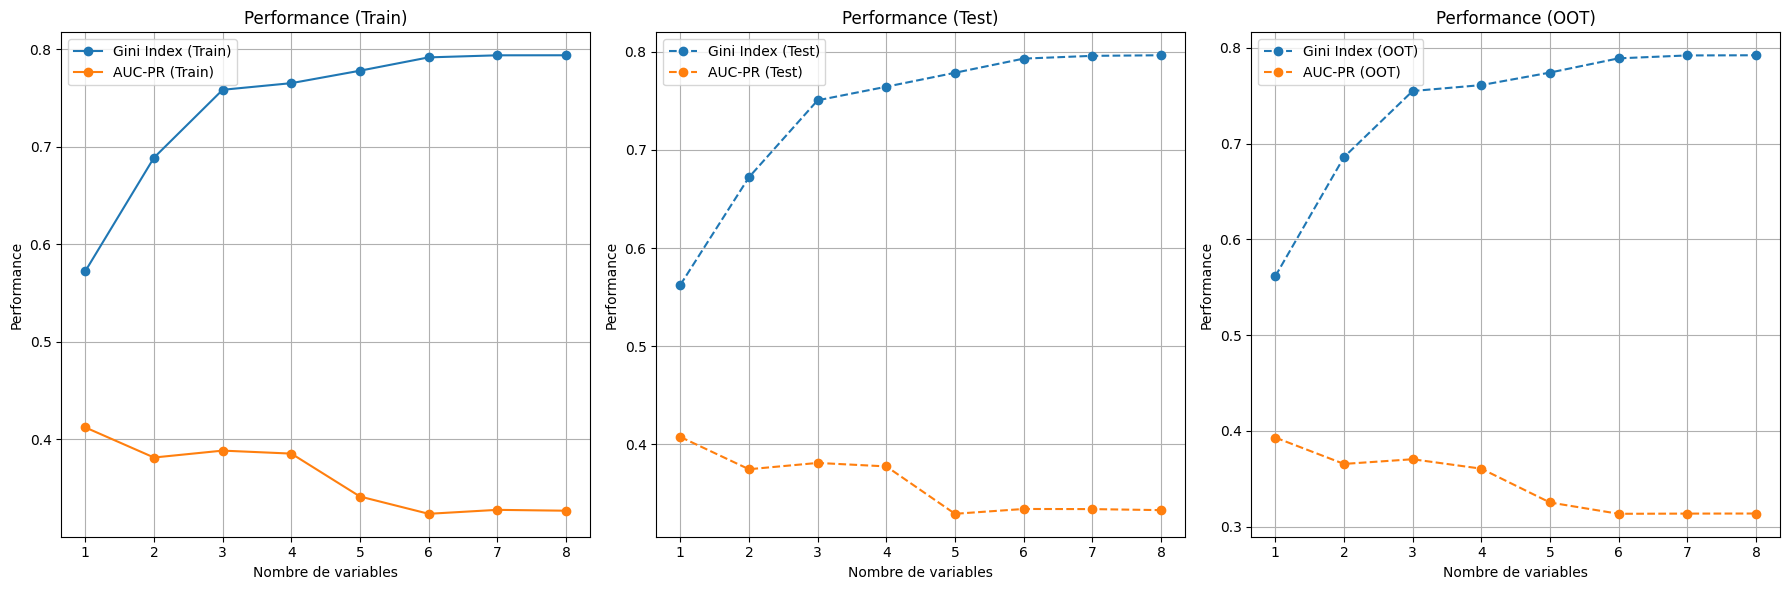

In [23]:
import matplotlib.pyplot as plt

# Création de la figure avec une disposition optimisée
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 ligne, 3 colonnes

# Performance sur les données d'entraînement
axes[0].plot(results_df["Nb de variables"], results_df["Gini_train"], label="Gini Index (Train)", marker='o')
axes[0].plot(results_df["Nb de variables"], results_df["AUC-PR_train"], label="AUC-PR (Train)", marker='o')
axes[0].set_title("Performance (Train)")
axes[0].set_xlabel("Nombre de variables")
axes[0].set_ylabel("Performance")
axes[0].legend()
axes[0].grid()

# Performance sur les données de test
axes[1].plot(results_df["Nb de variables"], results_df["Gini_test"], label="Gini Index (Test)", marker='o', linestyle='--')
axes[1].plot(results_df["Nb de variables"], results_df["AUC-PR_test"], label="AUC-PR (Test)", marker='o', linestyle='--')
axes[1].set_title("Performance (Test)")
axes[1].set_xlabel("Nombre de variables")
axes[1].set_ylabel("Performance")
axes[1].legend()
axes[1].grid()

# Performance sur les données hors échantillon (OOT)
axes[2].plot(results_df["Nb de variables"], results_df["Gini_oot"], label="Gini Index (OOT)", marker='o', linestyle='--')
axes[2].plot(results_df["Nb de variables"], results_df["AUC-PR_oot"], label="AUC-PR (OOT)", marker='o', linestyle='--')
axes[2].set_title("Performance (OOT)")
axes[2].set_xlabel("Nombre de variables")
axes[2].set_ylabel("Performance")
axes[2].legend()
axes[2].grid()

# Ajustement des espacements entre les sous-graphiques
fig.tight_layout()
plt.show()


Selon le graphique ci-dessus et le tableau résumant les performances des modèles, le meilleur modèle à choisir est le modèle à trois variables.
En effet, il nous permet d'avoir le meilleur AUC-PR et un indice de gini de plus de 70%. De plus, tous ses coefficients sont significatifs et il n'y a pas de problème de multicolinéarité (VIF < 10). 

Par ailleurs, il ne semble pas avoir de surapprentissage car les performances sur le jeu de test et out of time sont similaires à celles sur le jeu d'entraînement.

In [24]:
# Extraire les modèles du meilleur modèle
vars_selected1 = results_df["Variables"].iloc[2]
vars_selected1

['CRTOC_IND_0015_dis', 'evol_line_deb_cr_dis', 'CRTOC_IND_0164_dis']

In [25]:
gini_index_train, auc_pr_train, gini_index_test, auc_pr_test, gini_index_test, auc_pr_test, flag_significativite, flag_VIF, flag_OR, model1, modalites_reference =functions.logit_reg(vars_selected1, cible, y_train, X_train_reg)

In [33]:
print(model1.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               396411
Model:                          Logit   Df Residuals:                   396403
Method:                           MLE   Df Model:                            7
Date:                Wed, 15 Jan 2025   Pseudo R-squ.:                  0.3240
Time:                        22:32:10   Log-Likelihood:                -25881.
converged:                       True   LL-Null:                       -38286.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                     -5.7979      0.035   -163.932      0.000      -5.867      -5.729
CRTOC_IND_0015_dis_(2.0, 8.0]              0.52

In [34]:
modalites_reference

['CRTOC_IND_0015_dis_(-inf, 2.0]',
 'evol_line_deb_cr_dis_(-6.42e-06, inf]',
 'CRTOC_IND_0164_dis_(160100.0, inf]']

In [35]:
coefficients = pd.Series(model1.params)

for modalite in modalites_reference:
    if modalite not in coefficients.index:
        coefficients[modalite] = 0

coefficients

const                                    -5.797870
CRTOC_IND_0015_dis_(2.0, 8.0]             0.528665
CRTOC_IND_0015_dis_(24.0, inf]            2.915182
CRTOC_IND_0015_dis_(8.0, 24.0]            1.027721
evol_line_deb_cr_dis_(-inf, -6.42e-06]    0.646967
evol_line_deb_cr_dis_missing              1.228818
CRTOC_IND_0164_dis_(-inf, 27800.0]        1.623957
CRTOC_IND_0164_dis_(27800.0, 160100.0]    0.885273
CRTOC_IND_0015_dis_(-inf, 2.0]            0.000000
evol_line_deb_cr_dis_(-6.42e-06, inf]     0.000000
CRTOC_IND_0164_dis_(160100.0, inf]        0.000000
dtype: float64

In [36]:
importlib.reload(functions)
SC_df = functions.compute_score(vars_selected1,coefficients,X_train_reg,cible)
SC_df

,Variables,Variable_Modality,Modalities_merge,coef,alpha_j,"SC(j, i)",CTR,p_k,tx_defaut,relative_gap,m,n,SC_j,q_j
3,CRTOC_IND_0015_dis,"(-inf, 2.0]","CRTOC_IND_0015_dis_(-inf, 2.0]",0.000000,2.915182,505.409802,0.291518,0.925746,0.008208,0.979179,4,3,486.280819,0.32034
0,CRTOC_IND_0015_dis,"(2.0, 8.0]","CRTOC_IND_0015_dis_(2.0, 8.0]",0.528665,2.915182,413.754334,0.291518,0.025105,0.032657,0.917155,4,3,486.280819,0.32034
2,CRTOC_IND_0015_dis,"(8.0, 24.0]","CRTOC_IND_0015_dis_(8.0, 24.0]",1.027721,2.915182,327.232159,0.291518,0.024485,0.060684,0.846054,4,3,486.280819,0.32034
1,CRTOC_IND_0015_dis,"(24.0, inf]","CRTOC_IND_0015_dis_(24.0, inf]",2.915182,2.915182,0.000000,0.291518,0.024664,0.394190,0.000000,4,3,486.280819,0.32034
9,CRTOC_IND_0164_dis,"(160100.0, inf]","CRTOC_IND_0164_dis_(160100.0, inf]",0.000000,1.623957,281.548045,0.162396,0.599983,0.003612,0.952946,3,3,194.511918,0.43903
8,CRTOC_IND_0164_dis,"(27800.0, 160100.0]","CRTOC_IND_0164_dis_(27800.0, 160100.0]",0.885273,1.623957,128.066827,0.162396,0.199800,0.010467,0.863636,3,3,194.511918,0.43903
7,CRTOC_IND_0164_dis,"(-inf, 27800.0]","CRTOC_IND_0164_dis_(-inf, 27800.0]",1.623957,1.623957,0.000000,0.162396,0.200216,0.076756,0.000000,3,3,194.511918,0.43903
6,evol_line_deb_cr_dis,"(-6.42e-06, inf]","evol_line_deb_cr_dis_(-6.42e-06, inf]",0.000000,1.228818,213.042153,0.122882,0.752941,0.005669,0.953521,3,3,179.396735,0.24063
4,evol_line_deb_cr_dis,"(-inf, -6.42e-06]","evol_line_deb_cr_dis_(-inf, -6.42e-06]",0.646967,1.228818,100.876392,0.122882,0.188236,0.043474,0.643555,3,3,179.396735,0.24063
5,evol_line_deb_cr_dis,missing,evol_line_deb_cr_dis_missing,1.228818,1.228818,0.000000,0.122882,0.058823,0.121966,0.000000,3,3,179.396735,0.24063


In [37]:
score = functions.calculate_individual_scores(SC_df, X_train_reg[vars_selected1+[cible]])

396411it [00:12, 30776.72it/s]


In [38]:
score["score"].groupby(score[cible]).describe()

,count,mean,std,min,25%,50%,75%,max
DDefaut_NDB,,,,,,,,
0,388631.0,869.985506,183.452037,0.0,786.957847,1000.000000,1000.000000,1000.0
1,7780.0,370.852408,350.232846,0.0,0.000000,327.232159,718.451955,1000.0


In [39]:
# Entree : données X_train_reg et SC_df
# sortie : un dataframe
# Objectif : Filtrer et afficher les individus ayant les modalités de référence (ie coef = 0) pour les variables explicatives

def filter_ref_modalities(X_train_reg, SC_df):
    # Filtrer les individus ayant les modalités de référence
    ref_modalities= {}
    for var in SC_df["Variables"].unique():
        ref_modalities[var] = SC_df[(SC_df["Variables"] == var) & (SC_df["coef"] == 0)]["Variable_Modality"].unique()

    print(ref_modalities)

    # Filtrer les individus ayant les modalités de référence
    filtered_df = X_train_reg.copy()
    for var, modalites in ref_modalities.items():
        filtered_df = filtered_df[filtered_df[var].isin(modalites)]
    return filtered_df

filtered_df = filter_ref_modalities(X_train_reg, SC_df)
filtered_df

{'CRTOC_IND_0015_dis': array(['(-inf, 2.0]'], dtype=object), 'CRTOC_IND_0164_dis': array(['(160100.0, inf]'], dtype=object), 'evol_line_deb_cr_dis': array(['(-6.42e-06, inf]'], dtype=object)}


,SECTNAF,CODETAJUR_I_dis,evol_line_deb_cr_dis,ratio_cred_ma_dis,CRTOC_MOY_MVTAFF_IND_0010_dis,CRTOC_AG_MVTAFF_2T_IND_0010_dis,CRTOC_AG_NBJCRE_2T_IND_0009_dis,CRTOC_IND_0164_dis,CRTOC_AG_LIGDEB_2T_IND_0015_dis,CRTOC_IND_0015_dis,DDefaut_NDB,datdelhis,CODNAF2
0,B,"[6,3,9,2,8]","(-6.42e-06, inf]","(16.282, 37.831]","(83571.0, inf]","(381432.0, inf]","(176.0, inf]","(160100.0, inf]","(-100.0, inf]","(-inf, 2.0]",0,2023-02-01,6820B
2,B,"[6,3,9,2,8]","(-6.42e-06, inf]","(37.831, 83.086]","(83571.0, inf]","(92950.0, 381432.0]","(176.0, inf]","(160100.0, inf]","(-100.0, inf]","(-inf, 2.0]",0,2023-03-01,6820B
3,B,"[6,3,9,2,8]","(-6.42e-06, inf]","(37.831, 83.086]","(83571.0, inf]","(381432.0, inf]","(176.0, inf]","(160100.0, inf]","(-100.0, inf]","(-inf, 2.0]",0,2023-01-01,6820B
4,B,"[6,3,9,2,8]","(-6.42e-06, inf]","(37.831, 83.086]","(-inf, 0.0]","(-inf, 92950.0]","(176.0, inf]","(160100.0, inf]","(-100.0, inf]","(-inf, 2.0]",0,2023-03-01,6820B
5,B,"[6,3,9,2,8]","(-6.42e-06, inf]","(37.831, 83.086]","(83571.0, inf]","(381432.0, inf]","(176.0, inf]","(160100.0, inf]","(-100.0, inf]","(-inf, 2.0]",0,2023-05-01,6820B
...,...,...,...,...,...,...,...,...,...,...,...,...,...
396403,B,"[6,3,9,2,8]","(-6.42e-06, inf]","(37.831, 83.086]","(-inf, 0.0]","(381432.0, inf]","(176.0, inf]","(160100.0, inf]","(-100.0, inf]","(-inf, 2.0]",0,2023-06-01,6820B
396404,B,"[6,3,9,2,8]","(-6.42e-06, inf]","(211.347, inf]","(83571.0, inf]","(381432.0, inf]","(176.0, inf]","(160100.0, inf]","(-100.0, inf]","(-inf, 2.0]",0,2023-05-01,6820B
396405,A,"[6,3,9,2,8]","(-6.42e-06, inf]","(211.347, inf]","(83571.0, inf]","(381432.0, inf]","(176.0, inf]","(160100.0, inf]","(-100.0, inf]","(-inf, 2.0]",0,2023-05-01,6820A
396407,B,"[6,3,9,2,8]","(-6.42e-06, inf]","(83.086, 211.347]","(-inf, 0.0]","(381432.0, inf]","(176.0, inf]","(160100.0, inf]","(-100.0, inf]","(-inf, 2.0]",0,2023-04-01,6820B


In [40]:
# proportion de défaut dans filtered data
filtered_df[cible].value_counts(normalize=True)

DDefaut_NDB
0    0.997329
1    0.002671
Name: proportion, dtype: float64

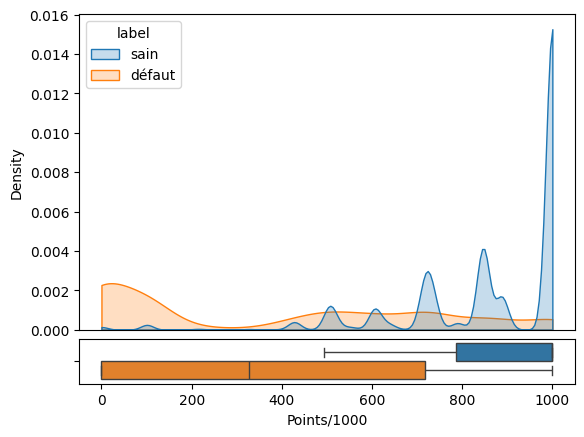

In [41]:
importlib.reload(functions)
functions.plot_kde_and_boxplot(score,cible)

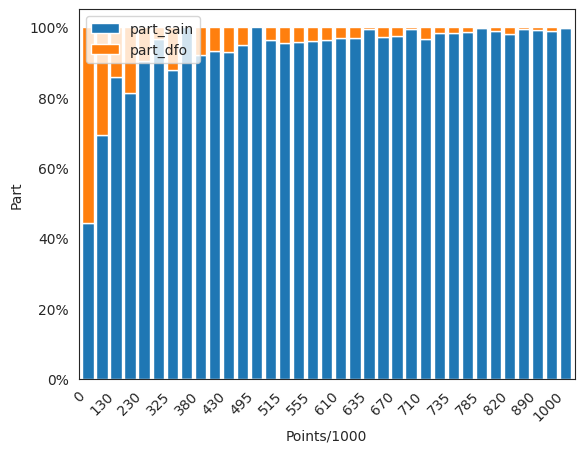

In [42]:
importlib.reload(functions)
functions.plot_bar_stacked(score,cible)

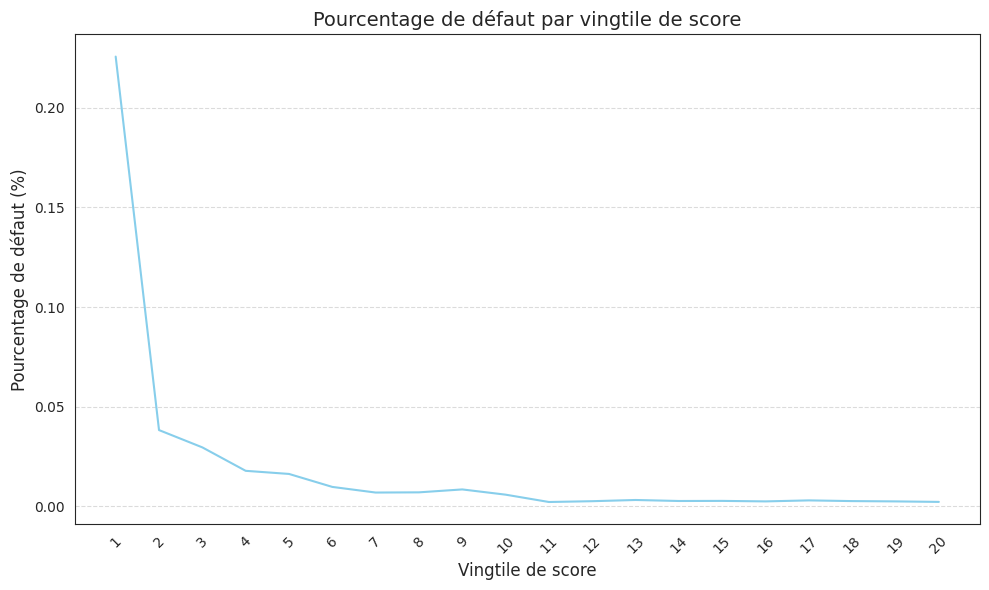

In [43]:
temp_df = score[["score",cible]].copy()

# Créer les vingtiles
# temp_df['ventile'] = pd.qcut(temp_df['score'], q=100, labels=False,duplicates='drop') +1
# temp_df['ventile'] = pd.cut(temp_df['score'], bins=20, labels=False) + 1

# Classer les scores pour leur attribuer des rangs uniques
temp_df['ranked_score'] = temp_df['score'].rank(method='first')

# Diviser les rangs en vingtiles
temp_df['ventile'] = pd.qcut(temp_df['ranked_score'], q=20, labels=False) + 1

# Calculer le pourcentage de défaut par vingtile
ventile_stats = temp_df.groupby('ventile')[cible].mean()# Pourcentage de défaut
ventile_stats.index = ventile_stats.index.astype(str)  # Conversion pour une meilleure lisibilité

# Tracer le graphique (Bar Chart pour une meilleure représentation des proportions)
plt.figure(figsize=(10, 6))
plt.plot(ventile_stats.index, ventile_stats, color='skyblue')  # Barres pour visualiser les pourcentages
plt.title("Pourcentage de défaut par vingtile de score", fontsize=14)
plt.xlabel("Vingtile de score", fontsize=12)
plt.ylabel("Pourcentage de défaut (%)", fontsize=12)
plt.xticks(rotation=45)  # Inclinaison des labels des x pour plus de lisibilité
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Pour cette deuxième démarche, on utilise toutes les variables selectionnées qu'on ajoute progressivement dans le modèle. On vérifie pour chaque variable (et donc notamment à chaque fois qu’une variable est ajoutée dans les modèles itératifs, mais aussi au global dans les modèles automatiques) la significativité des coefs et du modèle .

## I.2. Combinaison de variables (2)

L'idée est d'ici augmenter le nombre de variables explicatives pour voir si on peut améliorer les performances du modèle. On aimerait idéalement 6 variables explicatives. On va donc faire une combinaison de 5, 6 variables et de 7 variables parmi les 8 selectionnées.

### I.2.0. Combinaison de 5 variables

In [44]:
X_train_reg.columns

Index(['SECTNAF', 'CODETAJUR_I_dis', 'evol_line_deb_cr_dis',
       'ratio_cred_ma_dis', 'CRTOC_MOY_MVTAFF_IND_0010_dis',
       'CRTOC_AG_MVTAFF_2T_IND_0010_dis', 'CRTOC_AG_NBJCRE_2T_IND_0009_dis',
       'CRTOC_IND_0164_dis', 'CRTOC_AG_LIGDEB_2T_IND_0015_dis',
       'CRTOC_IND_0015_dis', 'DDefaut_NDB', 'datdelhis', 'CODNAF2'],
      dtype='object')

In [45]:
importlib.reload(functions)
nb_var=5
combi_var=functions.combinaisons(selected_vars,nb_var)
results = []
model_summaries = {}  # To store model summaries for each iteration

for cat_vars in tqdm(combi_var):
    gini_index_train, auc_pr_train, gini_index_test, auc_pr_test, gini_index_oot, auc_pr_oot, flag_significativite, \
    flag_VIF, flag_OR,model_train, modalites_reference = functions.logit_reg(list(cat_vars), cible, y_train,X_train_reg,y_test, X_test_reg,y_oot, X_oot_reg)
    # Stocker les résultats
    results.append({
        "Nb de variables": nb_var,
        "Variables": list(cat_vars).copy(),
        "Gini_train": gini_index_train,
        "Gini_test": gini_index_test,
        "Gini_oot": gini_index_oot,
        "AUC-PR_train": auc_pr_train,
        "AUC-PR_test": auc_pr_test,
        "AUC-PR_oot": auc_pr_oot,
        "flag_VIF": flag_VIF,
        "flag_significativite": flag_significativite,
        "flag_OR": flag_OR,
    })

    # Stocker le résumé du modèle
    model_summaries[f"Model_{i+1}"] = model_train.summary()

100%|██████████| 56/56 [06:00<00:00,  6.44s/it]


In [46]:
results_df= pd.DataFrame(results)
results_df

# show only when flag_VIF = 1, flag_significativite = 1, flag_OR = 1
results_df[(results_df["flag_VIF"] == 1) & (results_df["flag_significativite"] == 1) & (results_df["flag_OR"] == 1)]

,Nb de variables,Variables,Gini_train,Gini_test,Gini_oot,AUC-PR_train,AUC-PR_test,AUC-PR_oot,flag_VIF,flag_significativite,flag_OR
4,5,"[CRTOC_IND_0015_dis, evol_line_deb_cr_dis, CRT...",0.785804,0.788665,0.783695,0.404635,0.334870,0.383364,1,1,1
5,5,"[CRTOC_IND_0015_dis, evol_line_deb_cr_dis, CRT...",0.776733,0.777807,0.773468,0.348616,0.345010,0.319223,1,1,1
7,5,"[CRTOC_IND_0015_dis, evol_line_deb_cr_dis, CRT...",0.786557,0.786343,0.784485,0.346668,0.342489,0.323456,1,1,1
16,5,"[CRTOC_IND_0015_dis, evol_line_deb_cr_dis, CRT...",0.763249,0.768891,0.765335,0.353511,0.350334,0.327168,1,1,1
28,5,"[CRTOC_IND_0015_dis, CRTOC_IND_0164_dis, CRTOC...",0.758757,0.763284,0.752761,0.334788,0.328737,0.300326,1,1,1
34,5,"[CRTOC_IND_0015_dis, CRTOC_AG_MVTAFF_2T_IND_00...",0.721064,0.734066,0.716586,0.336932,0.333297,0.306506,1,1,1
41,5,"[evol_line_deb_cr_dis, CRTOC_IND_0164_dis, CRT...",0.760312,0.761918,0.761491,0.159853,0.157022,0.153142,1,1,1
42,5,"[evol_line_deb_cr_dis, CRTOC_IND_0164_dis, CRT...",0.757707,0.759458,0.759003,0.195249,0.191955,0.191643,1,1,1
43,5,"[evol_line_deb_cr_dis, CRTOC_IND_0164_dis, CRT...",0.744757,0.744321,0.744427,0.146899,0.139602,0.135296,1,1,1
44,5,"[evol_line_deb_cr_dis, CRTOC_IND_0164_dis, CRT...",0.757893,0.756087,0.759741,0.157819,0.152773,0.150527,1,1,1


Le modèle en indice 4 a la meilleure performance en terme de GINI et d'AUC-PR. 

In [47]:
vars_selected2 = results_df["Variables"].iloc[4]
print(vars_selected2)

['CRTOC_IND_0015_dis', 'evol_line_deb_cr_dis', 'CRTOC_IND_0164_dis', 'CRTOC_AG_MVTAFF_2T_IND_0010_dis', 'CRTOC_MOY_MVTAFF_IND_0010_dis']


In [48]:
gini_index_train, auc_pr_train, gini_index_test, auc_pr_test,gini_index_oot, auc_pr_oot, flag_significativite, flag_VIF, flag_OR, model2, modalites_reference =functions.logit_reg(vars_selected2, cible, y_train, X_train_reg)

In [49]:
print(model2.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               396411
Model:                          Logit   Df Residuals:                   396399
Method:                           MLE   Df Model:                           11
Date:                Wed, 15 Jan 2025   Pseudo R-squ.:                  0.3411
Time:                        22:39:16   Log-Likelihood:                -25228.
converged:                       True   LL-Null:                       -38286.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
const                                                  -6.2629      0.041   -153.920      0.000      -6.343      -6.183
CRTOC_IN

In [50]:
coefficients = pd.Series(model2.params)

for modalite in modalites_reference:
    if modalite not in coefficients.index:
        coefficients[modalite] = 0

coefficients

const                                                 -6.262932
CRTOC_IND_0015_dis_(2.0, 8.0]                          0.944698
CRTOC_IND_0015_dis_(24.0, inf]                         2.773149
CRTOC_IND_0015_dis_(8.0, 24.0]                         1.392368
evol_line_deb_cr_dis_(-inf, -6.42e-06]                 0.825988
evol_line_deb_cr_dis_missing                           0.908414
CRTOC_IND_0164_dis_(-inf, 27800.0]                     1.163762
CRTOC_IND_0164_dis_(27800.0, 160100.0]                 0.720163
CRTOC_AG_MVTAFF_2T_IND_0010_dis_(-inf, 92950.0]        0.390062
CRTOC_AG_MVTAFF_2T_IND_0010_dis_(92950.0, 381432.0]    0.289098
CRTOC_MOY_MVTAFF_IND_0010_dis_(-inf, 0.0]              0.999969
CRTOC_MOY_MVTAFF_IND_0010_dis_(0.0, 83571.0]           0.166975
CRTOC_IND_0015_dis_(-inf, 2.0]                         0.000000
evol_line_deb_cr_dis_(-6.42e-06, inf]                  0.000000
CRTOC_IND_0164_dis_(160100.0, inf]                     0.000000
CRTOC_AG_MVTAFF_2T_IND_0010_dis_(381432.

In [51]:
importlib.reload(functions)
SC_df = functions.compute_score(vars_selected2,coefficients,X_train_reg,cible)
SC_df

,Variables,Variable_Modality,Modalities_merge,coef,alpha_j,"SC(j, i)",CTR,p_k,tx_defaut,relative_gap,m,n,SC_j,q_j
12,CRTOC_AG_MVTAFF_2T_IND_0010_dis,"(381432.0, inf]","CRTOC_AG_MVTAFF_2T_IND_0010_dis_(381432.0, inf]",0.000000,0.390062,62.556551,0.039006,0.599996,0.007766,0.871627,3,5,40.772156,0.087094
11,CRTOC_AG_MVTAFF_2T_IND_0010_dis,"(92950.0, 381432.0]","CRTOC_AG_MVTAFF_2T_IND_0010_dis_(92950.0, 3814...",0.289098,0.390062,16.192223,0.039006,0.200002,0.014341,0.762927,3,5,40.772156,0.087094
10,CRTOC_AG_MVTAFF_2T_IND_0010_dis,"(-inf, 92950.0]","CRTOC_AG_MVTAFF_2T_IND_0010_dis_(-inf, 92950.0]",0.390062,0.390062,0.000000,0.039006,0.200002,0.060492,0.000000,3,5,40.772156,0.087094
3,CRTOC_IND_0015_dis,"(-inf, 2.0]","CRTOC_IND_0015_dis_(-inf, 2.0]",0.000000,2.773149,444.745929,0.277315,0.925746,0.008208,0.979179,4,5,424.505709,0.253770
0,CRTOC_IND_0015_dis,"(2.0, 8.0]","CRTOC_IND_0015_dis_(2.0, 8.0]",0.944698,2.773149,293.239263,0.277315,0.025105,0.032657,0.917155,4,5,424.505709,0.253770
2,CRTOC_IND_0015_dis,"(8.0, 24.0]","CRTOC_IND_0015_dis_(8.0, 24.0]",1.392368,2.773149,221.443805,0.277315,0.024485,0.060684,0.846054,4,5,424.505709,0.253770
1,CRTOC_IND_0015_dis,"(24.0, inf]","CRTOC_IND_0015_dis_(24.0, inf]",2.773149,2.773149,0.000000,0.277315,0.024664,0.394190,0.000000,4,5,424.505709,0.253770
9,CRTOC_IND_0164_dis,"(160100.0, inf]","CRTOC_IND_0164_dis_(160100.0, inf]",0.000000,1.163762,186.639232,0.116376,0.599983,0.003612,0.952946,3,5,126.194714,0.248037
8,CRTOC_IND_0164_dis,"(27800.0, 160100.0]","CRTOC_IND_0164_dis_(27800.0, 160100.0]",0.720163,1.163762,71.142480,0.116376,0.199800,0.010467,0.863636,3,5,126.194714,0.248037
7,CRTOC_IND_0164_dis,"(-inf, 27800.0]","CRTOC_IND_0164_dis_(-inf, 27800.0]",1.163762,1.163762,0.000000,0.116376,0.200216,0.076756,0.000000,3,5,126.194714,0.248037


In [52]:
importlib.reload(functions)
score = functions.calculate_individual_scores(SC_df, X_train_reg[vars_selected2+[cible]])

0it [00:00, ?it/s]

396411it [00:13, 28497.36it/s]


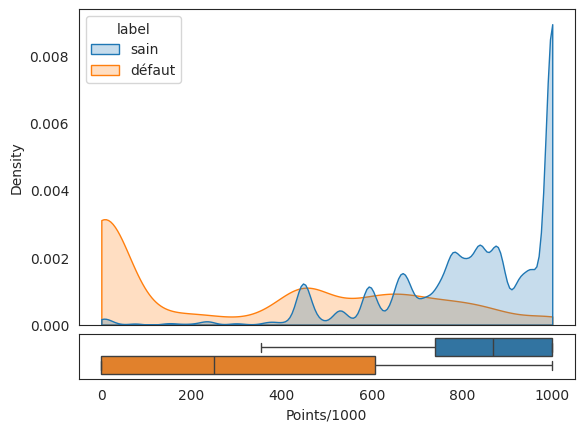

In [53]:
importlib.reload(functions)
functions.plot_kde_and_boxplot(score, cible)

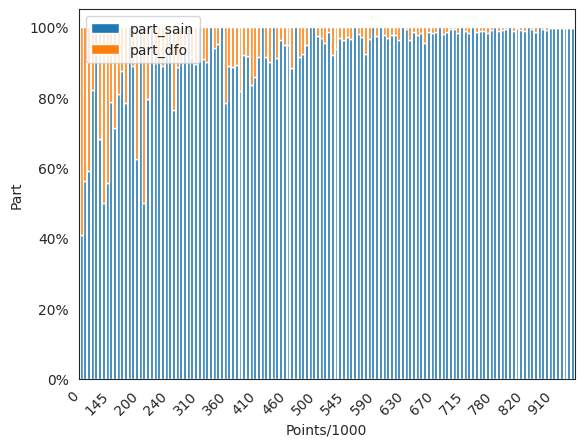

In [54]:
importlib.reload(functions)
functions.plot_bar_stacked(score, cible)

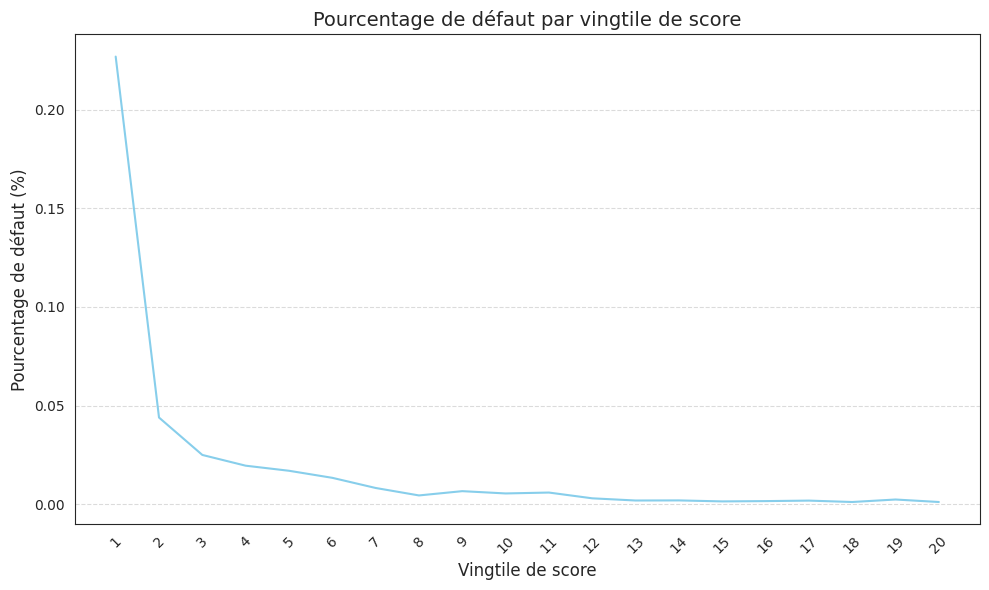

In [55]:
temp_df = score[["score",cible]].copy()

# Créer les vingtiles
# temp_df['ventile'] = pd.qcut(temp_df['score'], q=100, labels=False,duplicates='drop') +1
# temp_df['ventile'] = pd.cut(temp_df['score'], bins=20, labels=False) + 1

# Classer les scores pour leur attribuer des rangs uniques
temp_df['ranked_score'] = temp_df['score'].rank(method='first')

# Diviser les rangs en vingtiles
temp_df['ventile'] = pd.qcut(temp_df['ranked_score'], q=20, labels=False) + 1

# Calculer le pourcentage de défaut par vingtile
ventile_stats = temp_df.groupby('ventile')[cible].mean()# Pourcentage de défaut
ventile_stats.index = ventile_stats.index.astype(str)  # Conversion pour une meilleure lisibilité

# Tracer le graphique (Bar Chart pour une meilleure représentation des proportions)
plt.figure(figsize=(10, 6))
plt.plot(ventile_stats.index, ventile_stats, color='skyblue')  # Barres pour visualiser les pourcentages
plt.title("Pourcentage de défaut par vingtile de score", fontsize=14)
plt.xlabel("Vingtile de score", fontsize=12)
plt.ylabel("Pourcentage de défaut (%)", fontsize=12)
plt.xticks(rotation=45)  # Inclinaison des labels des x pour plus de lisibilité
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### I.2.1. Combinaison de 6 variables

In [56]:
importlib.reload(functions)
nb_var=6
combi_var=functions.combinaisons(selected_vars,nb_var)
results = []
model_summaries = {}  # To store model summaries for each iteration

for cat_vars in tqdm(combi_var):
    gini_index_train, auc_pr_train, gini_index_test, auc_pr_test, gini_index_oot, auc_pr_oot, flag_significativite, \
    flag_VIF, flag_OR,model_train, modalites_reference = functions.logit_reg(list(cat_vars), cible, y_train,X_train_reg,y_test, X_test_reg,y_oot, X_oot_reg)
    # Stocker les résultats
    results.append({
        "Nb de variables": nb_var,
        "Variables": list(cat_vars).copy(),
        "Gini_train": gini_index_train,
        "Gini_test": gini_index_test,
        "Gini_oot": gini_index_oot,
        "AUC-PR_train": auc_pr_train,
        "AUC-PR_test": auc_pr_test,
        "AUC-PR_oot": auc_pr_oot,
        "flag_VIF": flag_VIF,
        "flag_significativite": flag_significativite,
        "flag_OR": flag_OR,
    })

    # Stocker le résumé du modèle
    model_summaries[f"Model_{i+1}"] = model_train.summary()

100%|██████████| 28/28 [03:46<00:00,  8.11s/it]


In [57]:
results_df= pd.DataFrame(results)
results_df

# show only when flag_VIF = 1, flag_significativite = 1, flag_OR = 1
results_df[(results_df["flag_VIF"] == 1) & (results_df["flag_significativite"] == 1) & (results_df["flag_OR"] == 1)]

,Nb de variables,Variables,Gini_train,Gini_test,Gini_oot,AUC-PR_train,AUC-PR_test,AUC-PR_oot,flag_VIF,flag_significativite,flag_OR
6,6,"[CRTOC_IND_0015_dis, evol_line_deb_cr_dis, CRT...",0.788619,0.791349,0.787528,0.357285,0.322755,0.324764,1,1,1
25,6,"[evol_line_deb_cr_dis, CRTOC_IND_0164_dis, CRT...",0.760354,0.762769,0.762482,0.158793,0.155550,0.152847,1,1,1


In [58]:
vars_selected3 = results_df["Variables"].iloc[6]
print(vars_selected3)

['CRTOC_IND_0015_dis', 'evol_line_deb_cr_dis', 'CRTOC_IND_0164_dis', 'CRTOC_AG_MVTAFF_2T_IND_0010_dis', 'CRTOC_MOY_MVTAFF_IND_0010_dis', 'CODETAJUR_I_dis']


In [59]:
gini_index_train, auc_pr_train, gini_index_test, auc_pr_test, gini_index_oot, auc_pr_oot, flag_significativite, flag_VIF, flag_OR, model3, modalites_reference =functions.logit_reg(vars_selected3, cible, y_train, X_train_reg)

In [60]:
print(model3.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               396411
Model:                          Logit   Df Residuals:                   396398
Method:                           MLE   Df Model:                           12
Date:                Wed, 15 Jan 2025   Pseudo R-squ.:                  0.3424
Time:                        22:43:30   Log-Likelihood:                -25175.
converged:                       True   LL-Null:                       -38286.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
const                                                  -6.3078      0.041   -153.591      0.000      -6.388      -6.227
CRTOC_IN

In [61]:
coefficients = pd.Series(model3.params)

for modalite in modalites_reference:
    if modalite not in coefficients.index:
        coefficients[modalite] = 0

coefficients

const                                                 -6.307778
CRTOC_IND_0015_dis_(2.0, 8.0]                          0.944294
CRTOC_IND_0015_dis_(24.0, inf]                         2.770156
CRTOC_IND_0015_dis_(8.0, 24.0]                         1.391516
evol_line_deb_cr_dis_(-inf, -6.42e-06]                 0.810968
evol_line_deb_cr_dis_missing                           0.894996
CRTOC_IND_0164_dis_(-inf, 27800.0]                     1.175375
CRTOC_IND_0164_dis_(27800.0, 160100.0]                 0.731691
CRTOC_AG_MVTAFF_2T_IND_0010_dis_(-inf, 92950.0]        0.408892
CRTOC_AG_MVTAFF_2T_IND_0010_dis_(92950.0, 381432.0]    0.312369
CRTOC_MOY_MVTAFF_IND_0010_dis_(-inf, 0.0]              0.991111
CRTOC_MOY_MVTAFF_IND_0010_dis_(0.0, 83571.0]           0.165479
CODETAJUR_I_dis_[1,5]                                  0.488720
CRTOC_IND_0015_dis_(-inf, 2.0]                         0.000000
evol_line_deb_cr_dis_(-6.42e-06, inf]                  0.000000
CRTOC_IND_0164_dis_(160100.0, inf]      

In [62]:
importlib.reload(functions)
SC_df = functions.compute_score(vars_selected3,coefficients,X_train_reg,cible)
SC_df

,Variables,Variable_Modality,Modalities_merge,coef,alpha_j,"SC(j, i)",CTR,p_k,tx_defaut,relative_gap,m,n,SC_j,q_j
17,CODETAJUR_I_dis,"[6,3,9,2,8]","CODETAJUR_I_dis_[6,3,9,2,8]",0.000000,0.488720,72.626182,0.048872,0.942408,0.018823,0.425489,2,6,68.443514,0.055175
16,CODETAJUR_I_dis,"[1,5]","CODETAJUR_I_dis_[1,5]",0.488720,0.488720,0.000000,0.048872,0.057592,0.032764,0.000000,2,6,68.443514,0.055175
12,CRTOC_AG_MVTAFF_2T_IND_0010_dis,"(381432.0, inf]","CRTOC_AG_MVTAFF_2T_IND_0010_dis_(381432.0, inf]",0.000000,0.408892,60.763451,0.040889,0.599996,0.007766,0.871627,3,6,39.326619,0.086884
11,CRTOC_AG_MVTAFF_2T_IND_0010_dis,"(92950.0, 381432.0]","CRTOC_AG_MVTAFF_2T_IND_0010_dis_(92950.0, 3814...",0.312369,0.408892,14.343825,0.040889,0.200002,0.014341,0.762927,3,6,39.326619,0.086884
10,CRTOC_AG_MVTAFF_2T_IND_0010_dis,"(-inf, 92950.0]","CRTOC_AG_MVTAFF_2T_IND_0010_dis_(-inf, 92950.0]",0.408892,0.408892,0.000000,0.040889,0.200002,0.060492,0.000000,3,6,39.326619,0.086884
3,CRTOC_IND_0015_dis,"(-inf, 2.0]","CRTOC_IND_0015_dis_(-inf, 2.0]",0.000000,2.770156,411.658902,0.277016,0.925746,0.008208,0.979179,4,6,392.919795,0.238961
0,CRTOC_IND_0015_dis,"(2.0, 8.0]","CRTOC_IND_0015_dis_(2.0, 8.0]",0.944294,2.770156,271.332160,0.277016,0.025105,0.032657,0.917155,4,6,392.919795,0.238961
2,CRTOC_IND_0015_dis,"(8.0, 24.0]","CRTOC_IND_0015_dis_(8.0, 24.0]",1.391516,2.770156,204.872655,0.277016,0.024485,0.060684,0.846054,4,6,392.919795,0.238961
1,CRTOC_IND_0015_dis,"(24.0, inf]","CRTOC_IND_0015_dis_(24.0, inf]",2.770156,2.770156,0.000000,0.277016,0.024664,0.394190,0.000000,4,6,392.919795,0.238961
9,CRTOC_IND_0164_dis,"(160100.0, inf]","CRTOC_IND_0164_dis_(160100.0, inf]",0.000000,1.175375,174.666499,0.117537,0.599983,0.003612,0.952946,3,6,117.970526,0.236417


In [63]:
importlib.reload(functions)
score = functions.calculate_individual_scores(SC_df, X_train_reg[vars_selected3+[cible]])

396411it [00:13, 29666.43it/s]


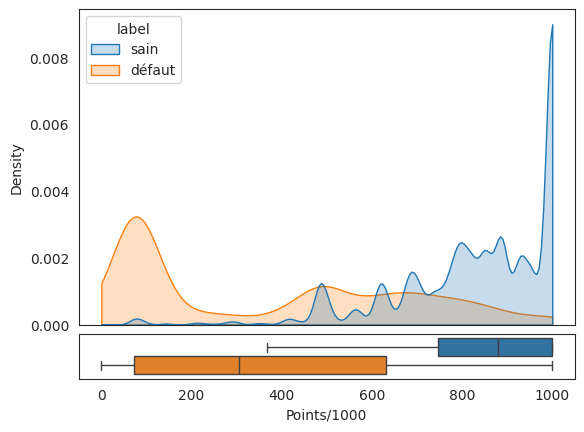

In [64]:
importlib.reload(functions)
functions.plot_kde_and_boxplot(score, cible)

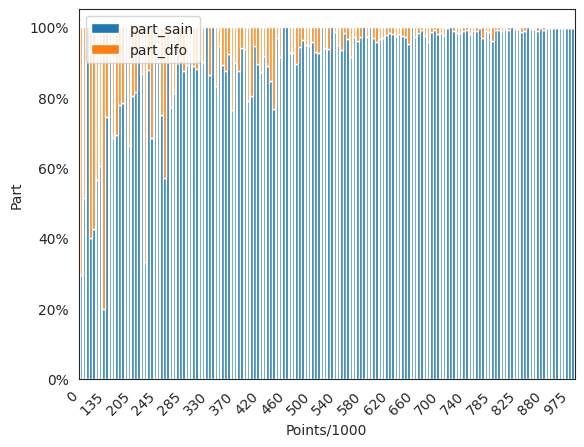

In [65]:
importlib.reload(functions)
functions.plot_bar_stacked(score, cible)

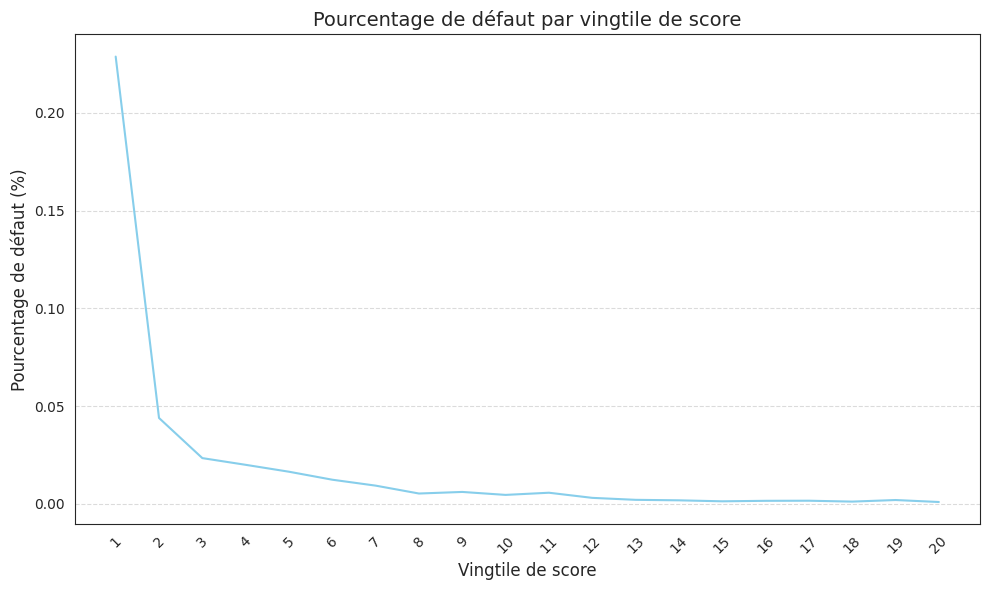

In [66]:
temp_df = score[["score",cible]].copy()

# Créer les vingtiles
# temp_df['ventile'] = pd.qcut(temp_df['score'], q=100, labels=False,duplicates='drop') +1
# temp_df['ventile'] = pd.cut(temp_df['score'], bins=20, labels=False) + 1

# Classer les scores pour leur attribuer des rangs uniques
temp_df['ranked_score'] = temp_df['score'].rank(method='first')

# Diviser les rangs en vingtiles
temp_df['ventile'] = pd.qcut(temp_df['ranked_score'], q=20, labels=False) + 1

# Calculer le pourcentage de défaut par vingtile
ventile_stats = temp_df.groupby('ventile')[cible].mean()# Pourcentage de défaut
ventile_stats.index = ventile_stats.index.astype(str)  # Conversion pour une meilleure lisibilité

# Tracer le graphique (Bar Chart pour une meilleure représentation des proportions)
plt.figure(figsize=(10, 6))
plt.plot(ventile_stats.index, ventile_stats, color='skyblue')  # Barres pour visualiser les pourcentages
plt.title("Pourcentage de défaut par vingtile de score", fontsize=14)
plt.xlabel("Vingtile de score", fontsize=12)
plt.ylabel("Pourcentage de défaut (%)", fontsize=12)
plt.xticks(rotation=45)  # Inclinaison des labels des x pour plus de lisibilité
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### I.2.2. Combinaison de 7 variables

In [67]:
importlib.reload(functions)
nb_var=7
combi_var=functions.combinaisons(selected_vars,nb_var)
results = []
model_summaries = {}  # To store model summaries for each iteration

for cat_vars in tqdm(combi_var):
    gini_index_train, auc_pr_train, gini_index_test, auc_pr_test, gini_index_oot, auc_pr_oot, flag_significativite, \
    flag_VIF, flag_OR,model_train, modalites_reference = functions.logit_reg(list(cat_vars), cible, y_train,X_train_reg,y_test, X_test_reg,y_oot, X_oot_reg)
    # Stocker les résultats
    results.append({
        "Nb de variables": nb_var,
        "Variables": list(cat_vars).copy(),
        "Gini_train": gini_index_train,
        "Gini_test": gini_index_test,
        "Gini_oot": gini_index_oot,
        "AUC-PR_train": auc_pr_train,
        "AUC-PR_test": auc_pr_test,
        "AUC-PR_oot": auc_pr_oot,
        "flag_VIF": flag_VIF,
        "flag_significativite": flag_significativite,
        "flag_OR": flag_OR,
    })

    # Stocker le résumé du modèle
    model_summaries[f"Model_{i+1}"] = model_train.summary()

100%|██████████| 8/8 [01:30<00:00, 11.28s/it]


In [68]:
results_df= pd.DataFrame(results)
results_df

# show only when flag_VIF = 1, flag_significativite = 1, flag_OR = 1
results_df[(results_df["flag_VIF"] == 1) & (results_df["flag_significativite"] == 1) & (results_df["flag_OR"] == 1)]

,Nb de variables,Variables,Gini_train,Gini_test,Gini_oot,AUC-PR_train,AUC-PR_test,AUC-PR_oot,flag_VIF,flag_significativite,flag_OR


En essayant de faire une régression logistique avec 7 variables, aucun modèle ne passent le test de significativité globale du modèle. On peut s'arrêter à une combinaisons de 6 variables.

## I.3 Comparaison des modèles de regression logistique

In [69]:
print(model1.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               396411
Model:                          Logit   Df Residuals:                   396403
Method:                           MLE   Df Model:                            7
Date:                Wed, 15 Jan 2025   Pseudo R-squ.:                  0.3240
Time:                        22:47:46   Log-Likelihood:                -25881.
converged:                       True   LL-Null:                       -38286.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                     -5.7979      0.035   -163.932      0.000      -5.867      -5.729
CRTOC_IND_0015_dis_(2.0, 8.0]              0.52

In [70]:
print(model2.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               396411
Model:                          Logit   Df Residuals:                   396399
Method:                           MLE   Df Model:                           11
Date:                Wed, 15 Jan 2025   Pseudo R-squ.:                  0.3411
Time:                        22:47:47   Log-Likelihood:                -25228.
converged:                       True   LL-Null:                       -38286.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
const                                                  -6.2629      0.041   -153.920      0.000      -6.343      -6.183
CRTOC_IN

In [71]:
print(model3.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               396411
Model:                          Logit   Df Residuals:                   396398
Method:                           MLE   Df Model:                           12
Date:                Wed, 15 Jan 2025   Pseudo R-squ.:                  0.3424
Time:                        22:47:48   Log-Likelihood:                -25175.
converged:                       True   LL-Null:                       -38286.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
const                                                  -6.3078      0.041   -153.591      0.000      -6.388      -6.227
CRTOC_IN

## I.4 Forward selection

In [72]:
importlib.reload(functions)
X_train,_,_,_ = functions.transf_logit_reg(selected_vars, cible, X_train_reg, X_test_reg,X_oot_reg)

In [73]:
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc


bestModelsForEachIteration = []
inputVariablesNames = selected_vars.copy()
quantityOfInputVariables = len(inputVariablesNames)
selectedVariables = ["const"]
final_variables = []
selectedAIC = []
selectedGini = []

X = X_train.copy()


for iteration in tqdm(range(quantityOfInputVariables)):
    bestCurrentModel = None
    LowestCurrentAIC = 1e8
    bestCurrentVariable = None
    for inputVariableName in inputVariablesNames:
        # fit model
        dummies_columns = X_train.filter(like=inputVariableName, axis=1).columns.to_list()
        regr_model = sm.Logit(y_train,X[selectedVariables + dummies_columns]).fit(disp=0)
        # get the aic value
        aic_model = regr_model.aic
        # assign lowest aic_value and corresponding model and variables
        if aic_model <= LowestCurrentAIC:
            bestCurrentModel = regr_model
            bestCurrentVariable = inputVariableName
            LowestCurrentAIC = aic_model
            # Prédictions et métriques pour les données OOT (si disponibles)
            y_pred = regr_model.predict(X[selectedVariables + dummies_columns])
            auc_roc = roc_auc_score(y_train, y_pred)
            gini_index = 2 * auc_roc - 1
    # put the best parameters(aci,variables, model) into the corresponding list
    bestModelsForEachIteration.append(bestCurrentModel)
    selectedAIC.append(LowestCurrentAIC)
    selectedGini.append(gini_index)
    X_train.filter(like=bestCurrentVariable, axis=1).columns.to_list()
    selectedVariables += X_train.filter(like=bestCurrentVariable, axis=1).columns.to_list()
    final_variables.append(bestCurrentVariable)
    # remove the selected variable
    inputVariablesNames.remove(bestCurrentVariable)

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:27<00:00,  3.42s/it]


In [74]:
# import pandas as pd

# # Créer un DataFrame pour un tableau récapitulatif
# summary_df = pd.DataFrame({
#     "Iteration": range(len(selectedAIC)),
#     "AIC": selectedAIC,
#     "Gini": selectedGini
# })

# # Trouver les indices des meilleurs modèles selon AIC et Gini
# best_aic_index = selectedAIC.index(min(selectedAIC))
# best_gini_index = selectedGini.index(max(selectedGini))

# # Afficher le tableau et les indices
# print("Tableau récapitulatif :")
# print(summary_df)
# print("\nIndice du meilleur modèle selon l'AIC :", best_aic_index)
# print("Indice du meilleur modèle selon le Gini :", best_gini_index)


Tableau récapitulatif :
   Iteration           AIC      Gini
0          0  55356.990443  0.572379
1          1  52679.317765  0.738689
2          2  51181.191067  0.766363
3          3  50563.025374  0.784750
4          4  50469.239639  0.786557
5          5  50373.257433  0.791634
6          6  50256.270157  0.793698
7          7  50256.483255  0.793745

Indice du meilleur modèle selon l'AIC : 6
Indice du meilleur modèle selon le Gini : 7


In [75]:
import pandas as pd

# Créer un DataFrame pour un tableau récapitulatif
summary_df = pd.DataFrame({
    "Iteration": range(len(selectedAIC)),
    "AIC": selectedAIC,
    "Gini": selectedGini
})

# Trouver les indices des meilleurs modèles selon AIC et Gini
best_aic_index = selectedAIC.index(min(selectedAIC))
best_gini_index = selectedGini.index(max(selectedGini))

# Calcul des variables pour le meilleur modèle selon AIC
bestmodel_variable_forward = selectedVariables[:best_aic_index + 1]
num_variables_forward = len(bestmodel_variable_forward)

# Ajouter une colonne pour le nombre de variables (facultatif)
summary_df['Num Variables'] = [len(selectedVariables[:i + 1]) for i in range(len(selectedAIC))]

# Afficher le tableau et les indices
print("Tableau récapitulatif :")
print(summary_df)
print("\nIndice du meilleur modèle selon l'AIC :", best_aic_index)
print("Indice du meilleur modèle selon le Gini :", best_gini_index)
print("Variables du meilleur modèle selon l'AIC :", bestmodel_variable_forward)
print("Nombre de variables dans le meilleur modèle :", num_variables_forward)


Tableau récapitulatif :
   Iteration           AIC      Gini  Num Variables
0          0  55356.990443  0.572379              1
1          1  52679.317765  0.738689              2
2          2  51181.191067  0.766363              3
3          3  50563.025374  0.784750              4
4          4  50469.239639  0.786557              5
5          5  50373.257433  0.791634              6
6          6  50256.270157  0.793698              7
7          7  50256.483255  0.793745              8

Indice du meilleur modèle selon l'AIC : 6
Indice du meilleur modèle selon le Gini : 7
Variables du meilleur modèle selon l'AIC : ['const', 'CRTOC_IND_0015_dis_(2.0, 8.0]', 'CRTOC_IND_0015_dis_(24.0, inf]', 'CRTOC_IND_0015_dis_(8.0, 24.0]', 'CRTOC_IND_0164_dis_(-inf, 27800.0]', 'CRTOC_IND_0164_dis_(27800.0, 160100.0]', 'CRTOC_MOY_MVTAFF_IND_0010_dis_(-inf, 0.0]']
Nombre de variables dans le meilleur modèle : 7


Le modèle à 5 variables semblent pas mal pour la suite bien que le modèle à 6 variables ait un meilleur Gini. On va donc choisir le modèle à 5 variables pour la suite.

In [78]:

# choose the lowest_aic_value model
bestmodel_index_forward = selectedAIC.index(min(selectedAIC))

bestmodel_model_forward = bestModelsForEachIteration[bestmodel_index_forward]

bestmodel_variable_forward = final_variables[: bestmodel_index_forward+1]

print("bestmodel_index:", bestmodel_index_forward, "bestmodel_variables:",bestmodel_variable_forward)

bestmodel_index: 6 bestmodel_variables: ['CRTOC_IND_0015_dis', 'CRTOC_IND_0164_dis', 'CRTOC_MOY_MVTAFF_IND_0010_dis', 'evol_line_deb_cr_dis', 'CODETAJUR_I_dis', 'ratio_cred_ma_dis', 'CRTOC_AG_MVTAFF_2T_IND_0010_dis']


In [79]:
gini_index_train, auc_pr_train, gini_index_test, auc_pr_test, gini_index_test, auc_pr_test, flag_significativite, flag_VIF, flag_OR, model4, modalites_reference =functions.logit_reg(bestmodel_variable_forward, cible, y_train, X_train_reg)

In [80]:
# print flag_significativite, flag_VIF, flag_OR,

print(model4.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               396411
Model:                          Logit   Df Residuals:                   396393
Method:                           MLE   Df Model:                           17
Date:                Wed, 15 Jan 2025   Pseudo R-squ.:                  0.3441
Time:                        22:51:16   Log-Likelihood:                -25110.
converged:                       True   LL-Null:                       -38286.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
const                                                  -6.5266      0.062   -104.438      0.000      -6.649      -6.404
CRTOC_IN

In [81]:
coefficients_test = pd.Series(model4.params)

for modalite in modalites_reference:
    if modalite not in coefficients_test.index:
        coefficients_test[modalite] = 0

coefficients_test

const                                                 -6.526612
CRTOC_IND_0015_dis_(2.0, 8.0]                          0.931080
CRTOC_IND_0015_dis_(24.0, inf]                         2.767978
CRTOC_IND_0015_dis_(8.0, 24.0]                         1.372854
CRTOC_IND_0164_dis_(-inf, 27800.0]                     1.013147
CRTOC_IND_0164_dis_(27800.0, 160100.0]                 0.607187
CRTOC_MOY_MVTAFF_IND_0010_dis_(-inf, 0.0]              1.065841
CRTOC_MOY_MVTAFF_IND_0010_dis_(0.0, 83571.0]           0.200070
evol_line_deb_cr_dis_(-inf, -6.42e-06]                 0.721316
evol_line_deb_cr_dis_missing                           0.762449
CODETAJUR_I_dis_[1,5]                                  0.497725
ratio_cred_ma_dis_(-inf, 16.282]                       0.521799
ratio_cred_ma_dis_(16.282, 37.831]                     0.387847
ratio_cred_ma_dis_(211.347, inf]                      -0.003705
ratio_cred_ma_dis_(37.831, 83.086]                     0.114460
ratio_cred_ma_dis_missing               

In [82]:
importlib.reload(functions)
SC_df_test = functions.compute_score(bestmodel_variable_forward,coefficients_test,X_train_reg,cible)
SC_df_test

,Variables,Variable_Modality,Modalities_merge,coef,alpha_j,"SC(j, i)",CTR,p_k,tx_defaut,relative_gap,m,n,SC_j,q_j
14,CODETAJUR_I_dis,"[6,3,9,2,8]","CODETAJUR_I_dis_[6,3,9,2,8]",0.000000,0.497725,69.959754,0.049773,0.942408,0.018823,0.425489,2,7,65.930650,0.053047
13,CODETAJUR_I_dis,"[1,5]","CODETAJUR_I_dis_[1,5]",0.497725,0.497725,0.000000,0.049773,0.057592,0.032764,0.000000,2,7,65.930650,0.053047
22,CRTOC_AG_MVTAFF_2T_IND_0010_dis,"(381432.0, inf]","CRTOC_AG_MVTAFF_2T_IND_0010_dis_(381432.0, inf]",0.000000,0.485511,68.242961,0.048551,0.599996,0.007766,0.871627,3,7,44.602044,0.096097
21,CRTOC_AG_MVTAFF_2T_IND_0010_dis,"(92950.0, 381432.0]","CRTOC_AG_MVTAFF_2T_IND_0010_dis_(92950.0, 3814...",0.355441,0.485511,18.282528,0.048551,0.200002,0.014341,0.762927,3,7,44.602044,0.096097
20,CRTOC_AG_MVTAFF_2T_IND_0010_dis,"(-inf, 92950.0]","CRTOC_AG_MVTAFF_2T_IND_0010_dis_(-inf, 92950.0]",0.485511,0.485511,0.000000,0.048551,0.200002,0.060492,0.000000,3,7,44.602044,0.096097
3,CRTOC_IND_0015_dis,"(-inf, 2.0]","CRTOC_IND_0015_dis_(-inf, 2.0]",0.000000,2.767978,389.064202,0.276798,0.925746,0.008208,0.979179,4,7,371.458101,0.224674
0,CRTOC_IND_0015_dis,"(2.0, 8.0]","CRTOC_IND_0015_dis_(2.0, 8.0]",0.931080,2.767978,258.192546,0.276798,0.025105,0.032657,0.917155,4,7,371.458101,0.224674
2,CRTOC_IND_0015_dis,"(8.0, 24.0]","CRTOC_IND_0015_dis_(8.0, 24.0]",1.372854,2.767978,196.097303,0.276798,0.024485,0.060684,0.846054,4,7,371.458101,0.224674
1,CRTOC_IND_0015_dis,"(24.0, inf]","CRTOC_IND_0015_dis_(24.0, inf]",2.767978,2.767978,0.000000,0.276798,0.024664,0.394190,0.000000,4,7,371.458101,0.224674
6,CRTOC_IND_0164_dis,"(160100.0, inf]","CRTOC_IND_0164_dis_(160100.0, inf]",0.000000,1.013147,142.406939,0.101315,0.599983,0.003612,0.952946,3,7,96.842656,0.190883


In [83]:
score_test = functions.calculate_individual_scores(SC_df_test, X_train_reg[bestmodel_variable_forward+[cible]])

0it [00:00, ?it/s]

396411it [00:13, 28388.74it/s]


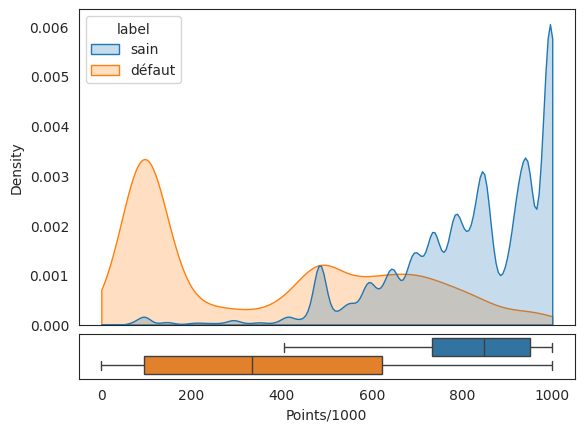

In [84]:
functions.plot_kde_and_boxplot(score_test, cible)

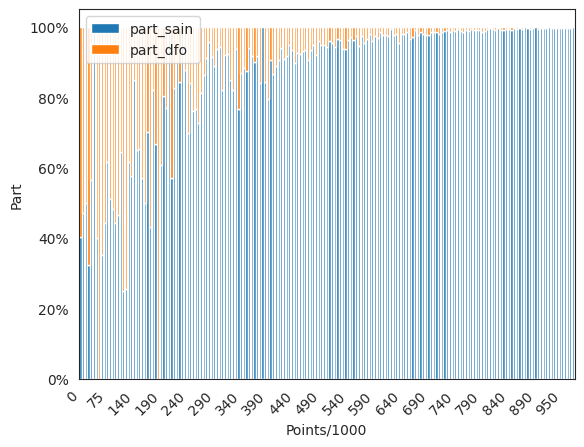

In [85]:
functions.plot_bar_stacked(score_test, cible)

In [86]:
flag_significativite, flag_VIF, flag_OR

(0, 1, 0)